<a href="https://colab.research.google.com/github/rociotarda/TP1---Datos/blob/main/TP1_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving train_values.csv to train_values.csv
Saving train_labels.csv to train_labels.csv


In [284]:
pip install squarify

In [285]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import squarify
import warnings
warnings.filterwarnings('ignore')

In [286]:
train_labels = pd.read_csv(io.BytesIO(uploaded['train_labels.csv']))
train_labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [287]:
train_values = pd.read_csv(io.BytesIO(uploaded['train_values.csv']))
train_values.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [288]:
buildings_with_damage = train_values.merge(train_labels)
buildings_with_damage.head(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
5,333020,8,558,6089,2,10,9,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,2
6,728451,9,475,12066,2,25,3,4,n,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
7,475515,20,323,12236,2,0,8,6,t,w,q,v,x,s,u,0,0,0,0,0,1,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1
8,441126,0,757,7219,2,15,8,6,t,r,q,f,q,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
9,989500,26,886,994,1,0,13,4,t,i,n,v,j,s,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1


In [289]:
buildings_with_damage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

# Grado de daño

In [290]:
damage_level = train_labels['damage_grade'].value_counts().to_frame().sort_index()
damage_level

,damage_grade
1,25124
2,148259
3,87218


Vemos que el daño realizado puede ser de nivel 1, 2, 3.

- El nivel 1 representa un daño menor
- El nivel 2 representa un daño mediano
- El nivel 3 representa un daño completo

Text(0.5, 1.0, 'Cantidad de edificios vs Grado de daño')

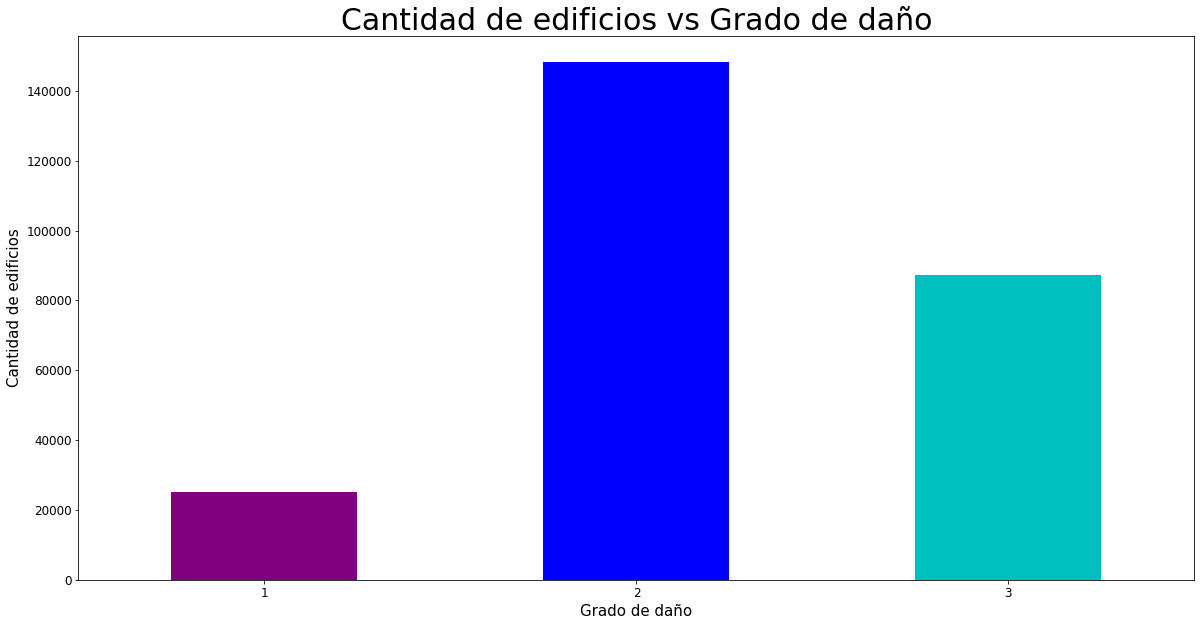

In [291]:
plot=damage_level['damage_grade'].plot(kind='bar',color=['purple', 'blue', 'c'], figsize=(20,10))
plt.xlabel("Grado de daño", size=15)
plt.ylabel("Cantidad de edificios", size=15)
plt.xticks(rotation=0)
plt.title("Cantidad de edificios vs Grado de daño", size = 30)

In [292]:
avg_total_damage_grade = train_labels['damage_grade'].mean()
avg_total_damage_grade

2.2382723013342236

In [293]:
damaged_buildings_count = train_labels['damage_grade'].value_counts().to_frame()
damaged_buildings_count

,damage_grade
2,148259
3,87218
1,25124


In [294]:
buildings_count = train_labels['damage_grade'].count()
buildings_count

260601

In [295]:
damaged_buildings_count['damaged_percentage'] = ((damaged_buildings_count['damage_grade'] / damaged_buildings_count['damage_grade'].sum() * 100)).astype(int)
damaged_buildings_count.rename({'index':'damage_level'})

,damage_grade,damaged_percentage
2,148259,56
3,87218,33
1,25124,9


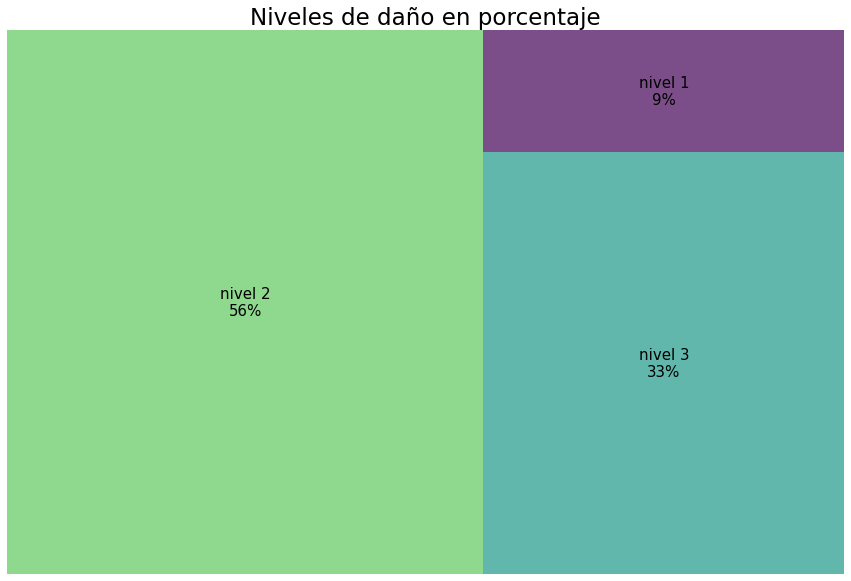

In [296]:
labels_damage = [f'nivel {index}\n{damage_grade}%' for index, damage_grade in zip(damaged_buildings_count.index, damaged_buildings_count.damaged_percentage)]

plt.figure(figsize=(15, 10))
plt.rc('font', size=12)
squarify.plot(sizes=damaged_buildings_count['damage_grade'], label=labels_damage, alpha=0.7, text_kwargs={'fontsize':15})

plt.title("Niveles de daño en porcentaje",fontsize=23)
plt.axis('off')
plt.show()

# Registros duplicados

Veamos si hay registros duplicados, sin tener en cuenta el building_id

In [297]:
train_values[train_values.duplicated(subset=list(train_values.columns)[1:],keep=False)].shape[0]

28544

In [298]:
train_values[train_values.duplicated(subset=list(train_values.columns)[1:],keep=False)].head(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
12,444381,12,335,8167,2,15,6,5,t,r,n,x,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
18,354011,26,1401,3904,1,20,12,3,t,u,n,v,j,s,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
48,987864,10,1097,399,2,20,7,4,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
59,302199,13,221,7919,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
71,708530,26,39,10795,1,0,17,3,t,i,x,v,j,s,d,0,0,0,0,0,0,0,0,0,1,0,v,1,0,0,0,0,0,0,0,0,0,0,0
76,425720,20,136,4769,2,0,5,7,t,w,q,f,x,s,d,0,0,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
103,96470,4,474,11771,2,10,8,7,n,r,n,z,q,s,d,0,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
105,820425,3,574,4163,3,30,6,8,t,r,n,f,q,t,d,1,0,0,0,1,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


De un total de 260601 registros, vemos que hay 28544 que son duplicados. Veamos si alguno de ellos es debido a que hay registros duplicados con building_id

In [299]:
len(set(train_values[train_values.duplicated(subset=list(train_values.columns)[1:],keep=False)].building_id))

28544

Tambien lo podemos ver con un value_counts de la columna:

In [300]:
train_values['building_id'].value_counts()

1052670    1
847304     1
368102     1
729986     1
900578     1
          ..
56753      1
946311     1
15789      1
13740      1
524288     1
Name: building_id, Length: 260601, dtype: int64

Esto quiere decir que estos registros "duplicados" comparten todas las columnas, pero parecería ser que no tienen el mismo building_id. Lo que puede suceder es que son edificios "residenciales" que se construyeron en el mismo lugar, con el mismo tamaño y de los mismos materiales de construcción. Veamos por ejemplo la cantidad de registros por geo_level_3_id:

In [301]:
train_values['geo_level_3_id'].value_counts()

633      651
9133     647
621      530
11246    470
2005     466
        ... 
6095       1
3599       1
7886       1
9994       1
11851      1
Name: geo_level_3_id, Length: 11595, dtype: int64

Viendo anteriormente alguno de los registros que parecen duplicados, agarremos el geo_level_3 = 2812

In [302]:
buildings_geo_3_2812 = train_values[train_values['geo_level_3_id']==2812]
buildings_geo_3_2812.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
17093,265547,8,900,2812,2,10,7,7,o,r,n,x,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
34007,674412,8,900,2812,2,15,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
51151,988427,8,900,2812,2,10,5,6,o,r,n,x,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
52872,111255,8,900,2812,3,15,11,8,o,r,n,x,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [303]:
buildings_geo_3_conditions = buildings_geo_3_2812.loc[(buildings_geo_3_2812['position']=='s') & (buildings_geo_3_2812['height_percentage']==7) & (buildings_geo_3_2812['age']==10), :]
buildings_geo_3_conditions.head(5)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
205258,938572,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


Vemos que hay dos registros identicos, con la diferencia que tienen un building_id distinto. El significado de esto puede ser lo mencionado anteriormente, que simplemente al ser residenciales y están ubicados en el mismo geo_level_3, son edificios que se contruyeron de la misma forma, y con el mismo fin. Borrarlos sería un error, ya que perderíamos un 10% de la información, siendo diferentes registros.

Otro ejemplo puede ser el siguiente, donde el building_id=590882 es igual a building_id=1006803

In [304]:
building_duplicated_2 = train_values.loc[(train_values['position']=='s') & (train_values['height_percentage']==5) & (train_values['age']==10) & (train_values['geo_level_3_id']==10694) & (train_values['other_floor_type']=='x'), :]
building_duplicated_2

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
138406,614984,22,418,10694,2,10,11,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
142884,1006803,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


# Geo level

Vemos la distribucion de los edificios en las zonas del geo level 1

In [305]:
geo_level_1 = buildings_with_damage.groupby('geo_level_1_id').agg({'building_id':'count'})
geo_level_1.reset_index(inplace=True)

col_rename1 = {'building_id':'amount_of_buildings'}
geo_level_1 = geo_level_1.rename(columns= col_rename1)

buldings_per_geo_level_1 = buildings_with_damage['geo_level_1_id'].value_counts()
buldings_per_geo_level_1.to_list()

amount_of_buildings = geo_level_1['amount_of_buildings'].value_counts().index

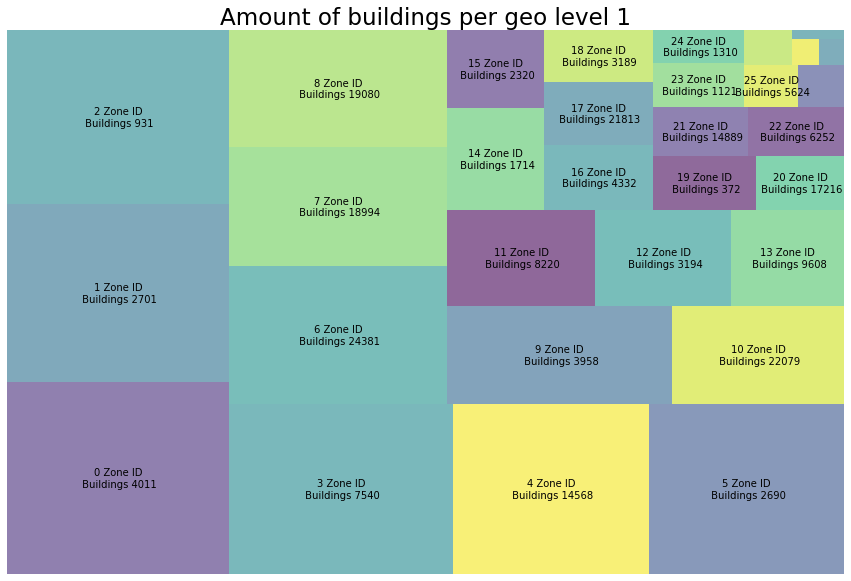

In [306]:
labels = [f'{geo_level_1_id} Zone ID\n Buildings {amount_of_buildings}' for amount_of_buildings, geo_level_1_id in zip(geo_level_1.amount_of_buildings, geo_level_1.geo_level_1_id)]

plt.figure(figsize=(15, 10))
plt.rc('font', size=12)
squarify.plot(sizes=buldings_per_geo_level_1, label=labels[:26], alpha=0.6, text_kwargs={'fontsize':10})

plt.title("Amount of buildings per geo level 1",fontsize=23)
plt.axis('off')
plt.show()

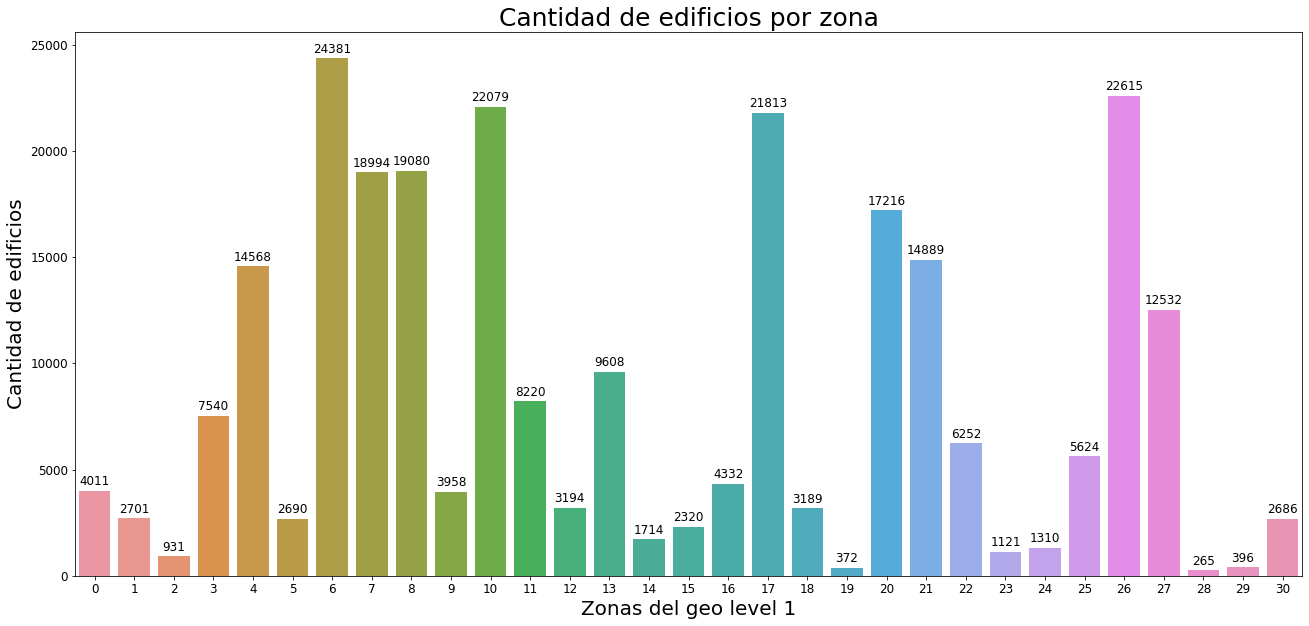

In [307]:
target = buildings_with_damage['geo_level_1_id'].value_counts()
plt.subplots(figsize=(22,10))
grafico=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico.patches:
    grafico.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico.set_title("Cantidad de edificios por zona",fontsize=25)
grafico.set_ylabel("Cantidad de edificios",fontsize=20)
grafico.set_xlabel("Zonas del geo level 1",fontsize=20);

Ahora analizando el daño promedio de cada una de las 30 zonas del geo level 1

In [308]:
damage_per_geo_level1 =  buildings_with_damage.groupby('geo_level_1_id').agg({'damage_grade': ['mean','count']})
damage_per_geo_level1.columns = damage_per_geo_level1.columns.get_level_values(0) + '_' + damage_per_geo_level1.columns.get_level_values(1)
damage_per_geo_level1.reset_index(inplace=True)

In [309]:
damage_geo_level1 = damage_per_geo_level1.sort_values('damage_grade_mean',ascending=False)
damage_geo_level1.head()

,geo_level_1_id,damage_grade_mean,damage_grade_count
17,17,2.794480,21813
18,18,2.708373,3189
21,21,2.563369,14889
8,8,2.485273,19080
27,27,2.446457,12532


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text major ticklabel objects>)

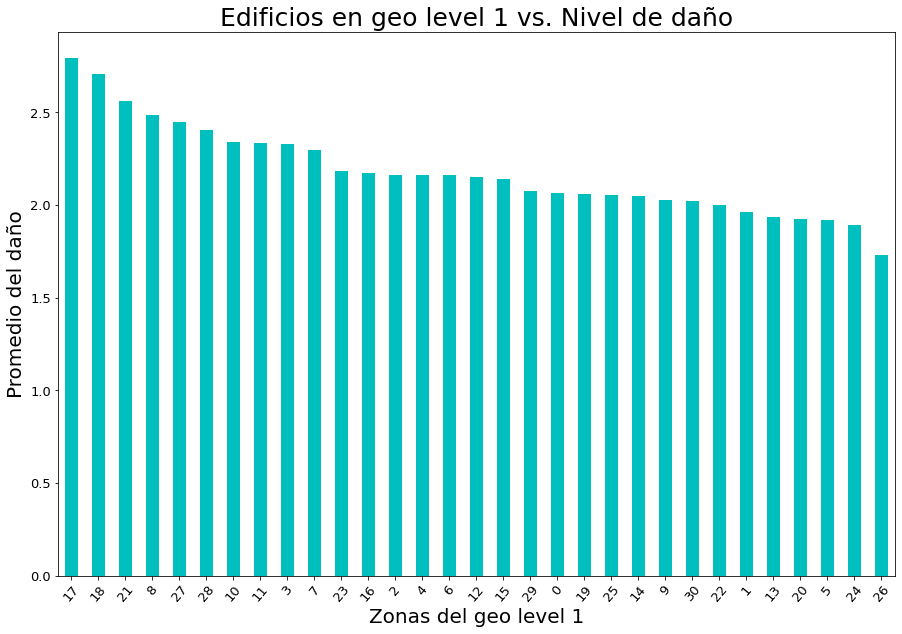

In [310]:
damage_geo_level1['damage_grade_mean'].plot.bar(stacked=True, figsize=(15,10), color=['c'])

plt.title("Edificios en geo level 1 vs. Nivel de daño", size = 25)
plt.xlabel("Zonas del geo level 1", size=20)
plt.ylabel("Promedio del daño", size=20)
plt.yticks(size = 13)
plt.xticks(rotation=50, size = 13)

Mas especificamente en las 5 zonas mas azotadas por el terremoto

In [311]:
damage_per_geo_level1.sort_values('damage_grade_count',ascending=False)

top_5_damage_per_geo_level1 = damage_per_geo_level1.nlargest(5,'damage_grade_mean').sort_values('damage_grade_mean',ascending=False)

top_5_damage_per_geo_level1

,geo_level_1_id,damage_grade_mean,damage_grade_count
17,17,2.794480,21813
18,18,2.708373,3189
21,21,2.563369,14889
8,8,2.485273,19080
27,27,2.446457,12532


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

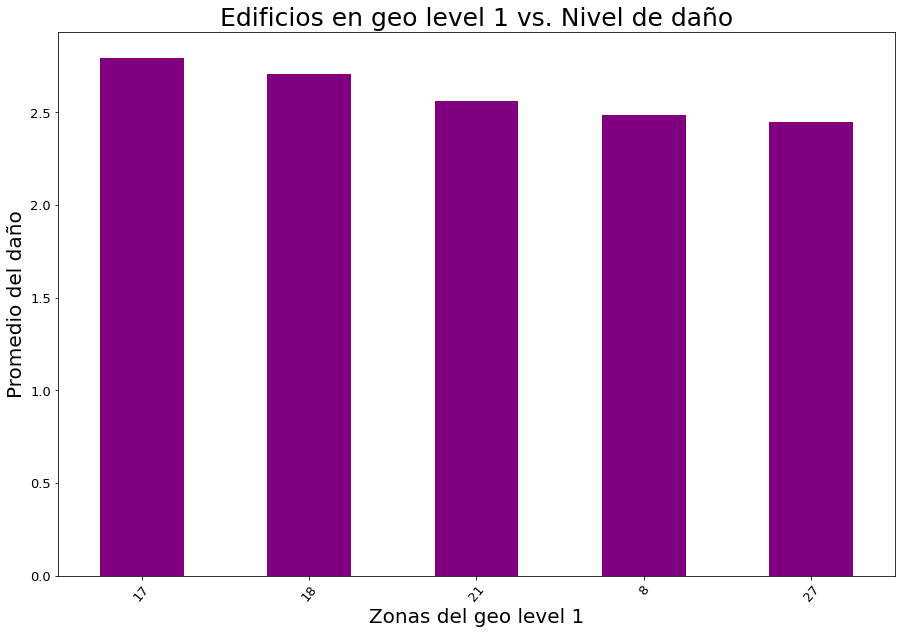

In [312]:
top_5_damage_per_geo_level1['damage_grade_mean'].plot.bar(stacked=True, figsize=(15,10), color=['purple'])

plt.title("Edificios en geo level 1 vs. Nivel de daño", size = 25)
plt.xlabel("Zonas del geo level 1", size=20)
plt.ylabel("Promedio del daño", size=20)
plt.yticks(size = 13)
plt.xticks(rotation=50, size = 13)

# Edad de los edificios

In [313]:
buildings_with_damage['age'].value_counts()

10     38896
15     36010
5      33697
20     32182
0      26041
25     24366
30     18028
35     10710
40     10559
50      7257
45      4711
60      3612
80      3055
55      2033
70      1975
995     1390
100     1364
65      1123
90      1085
85       847
75       512
95       414
120      180
150      142
200      106
110      100
105       89
125       37
115       21
140        9
130        9
180        7
160        6
170        6
175        5
135        5
145        3
190        3
195        2
165        2
155        1
185        1
Name: age, dtype: int64

A primera vista llama la atención que hay 1390 edificios que destruidos con 995 años de antiguedad. Haciendo una investigación acerca de Nepal, y más en concreto en el sudeste asiático, vemos que la historia se remonta a los años A.C., por lo que las construcciones de hace 1000 años, si bien llaman la atención son más que factibles.

Text(0.5, 0, 'Antiguedad de los edificios')

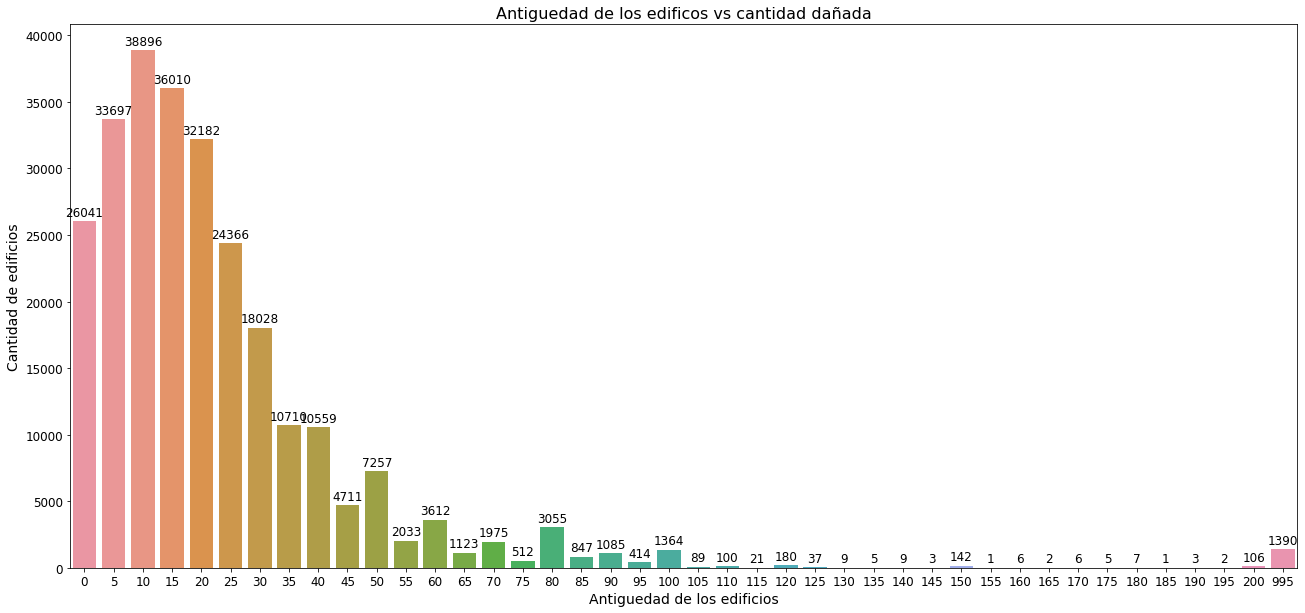

In [314]:
target = buildings_with_damage['age'].value_counts()
plt.subplots(figsize=(22,10))
grafico=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico.patches:
    grafico.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico.set_title("Antiguedad de los edificos vs cantidad dañada",fontsize=16)
grafico.set_ylabel("Cantidad de edificios",fontsize=14)
grafico.set_xlabel("Antiguedad de los edificios",fontsize=14)

Podemos tomar como hipotesis que al haber estos 995 edificios antiguos, se entienden que son construcciones antiguas, como por ejemplo templos. Cuando se generaron los datos, se habrá tomado la decisión de capear todos estos edificios como que tenian 995 años. Igualmente, tiene sentido que hayan solamente 1300 edificios con esa antiguedad destruido, comparado a la cantidad de editicios mas "recientes" que fueron destruidos.

Tambien podemos tomar como hipotesis lo mismo para la antiguedad de 200 años, ya que se habrá decidido capear a el resto de edificios de mayor antiguedad, como 205, 210, etc... hacia los 200 años.

Ahora veamos la comparación entre las antiguedades y el nivel de daño, no solo la cantidad que fueron dañados.

In [315]:
buildings_with_damage.head(5)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [316]:
damaged_buildings_by_age = buildings_with_damage.groupby(['age', 'damage_grade']).agg({'damage_grade':['count']})
damaged_buildings_by_age
level0 = damaged_buildings_by_age.columns.get_level_values(0)
level1 = damaged_buildings_by_age.columns.get_level_values(1)
damaged_buildings_by_age.columns = level0 + '_' + level1
damaged_buildings_by_age.reset_index(inplace=True)
damaged_buildings_by_age.rename(columns={'damage_grade':'Grado de daño'}, inplace=True)
damaged_buildings_by_age.head()

,age,Grado de daño,damage_grade_count
0,0,1,7213
1,0,2,12721
2,0,3,6107
3,5,1,5590
4,5,2,19030


In [317]:
damaged_buildings_age_pivot = damaged_buildings_by_age.pivot(index='age', columns='Grado de daño', values='damage_grade_count')

Text(0.5, 0, 'Antiguedad de los edificios')

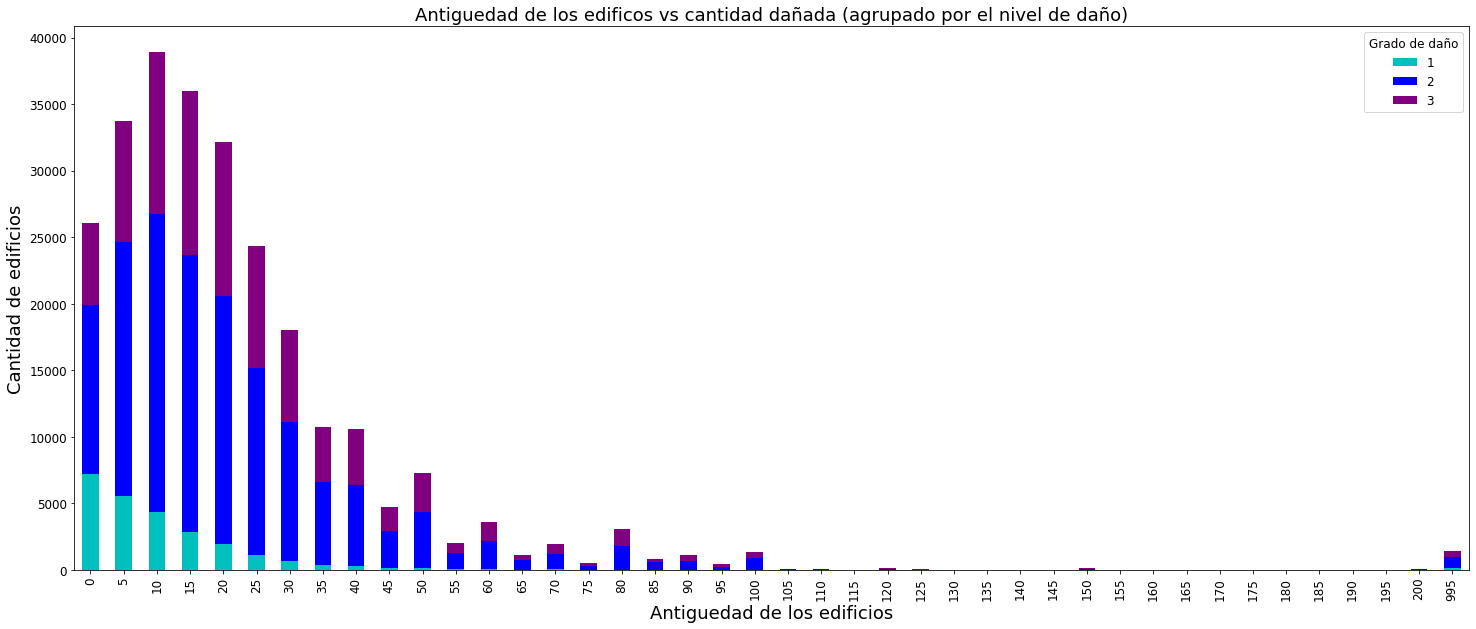

In [318]:
plot = damaged_buildings_age_pivot.plot.bar(stacked=True, figsize=(25,10), color=['c', 'blue', 'purple'])
plot.set_title("Antiguedad de los edificos vs cantidad dañada (agrupado por el nivel de daño)", fontsize=18)
plot.set_ylabel("Cantidad de edificios", fontsize=18)
plot.set_xlabel("Antiguedad de los edificios", fontsize=18)

Se puede observar que en general para todas las antiguedades de los edificios, la mayoría del daño provocado fue de nivel 2, seguido por el nivel 3 (destrucción completa)

# Cantidad de pisos

Veamos como se comportaron los edificios teniendo en cuenta la cantidad de pisos. Luego volveremos a retomar y lo compararemos con la antiguedad de los mismos.

In [319]:
damaged_by_floor = train_values['count_floors_pre_eq'].value_counts()
damaged_by_floor.to_list()
floors = train_values['count_floors_pre_eq'].value_counts().index

In [320]:
damage = {'damage': damaged_by_floor, 'floors': floors}
damage_df = pd.DataFrame(data=damage)
damage_df

,damage,floors
2,156623,2
3,55617,3
1,40441,1
4,5424,4
5,2246,5
6,209,6
7,39,7
9,1,9
8,1,8


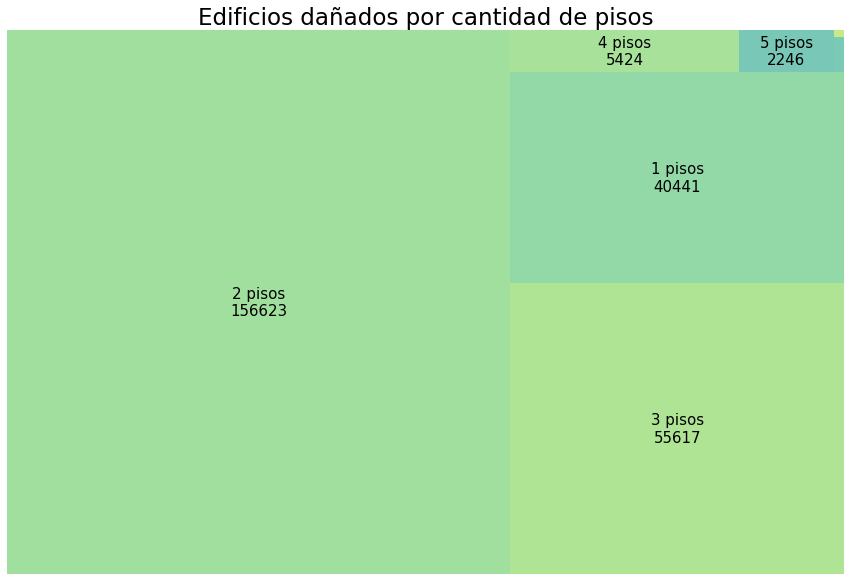

In [321]:
labels = [f'{floors} pisos\n{damage}' for damage, floors in zip(damage_df.damage, damage_df.floors)]

plt.figure(figsize=(15, 10))
plt.rc('font', size=12)
squarify.plot(sizes=damaged_by_floor, label=labels[:5], alpha=0.6, text_kwargs={'fontsize':15})

plt.title("Edificios dañados por cantidad de pisos",fontsize=23)
plt.axis('off')
plt.show()

Con este gráfico de heatmap podemos tener una noción de la proporción de los edificios dependiendo de la cantidad de pisos. Únicamente se muestran los labels para los 5 pisos más destruidos ya que si no se pisarían los labels en los pisos menores y no se apreciarían bien los datos.

Conociendo la cantidad de edificios que fueron destruidos por cantidad de pisos, veamos ahora como se distribuye el nivel de daño en cada uno de ellos

In [322]:
damaged_buildings_by_floor = buildings_with_damage.groupby(['count_floors_pre_eq', 'damage_grade']).agg({'damage_grade':['count']})
damaged_buildings_by_floor
level0 = damaged_buildings_by_floor.columns.get_level_values(0)
level1 = damaged_buildings_by_floor.columns.get_level_values(1)
damaged_buildings_by_floor.columns = level0 + '_' + level1
damaged_buildings_by_floor.reset_index(inplace=True)
damaged_buildings_by_floor.rename(columns={'damage_grade':'Grado de daño'}, inplace=True)
damaged_buildings_by_floor.head()

,count_floors_pre_eq,Grado de daño,damage_grade_count
0,1,1,8969
1,1,2,20798
2,1,3,10674
3,2,1,12593
4,2,2,93968


In [323]:
damaged_buildings_floors_pivot = damaged_buildings_by_floor.pivot(index='count_floors_pre_eq', columns='Grado de daño', values='damage_grade_count')

Text(0.5, 0, 'Cantidad de pisos')

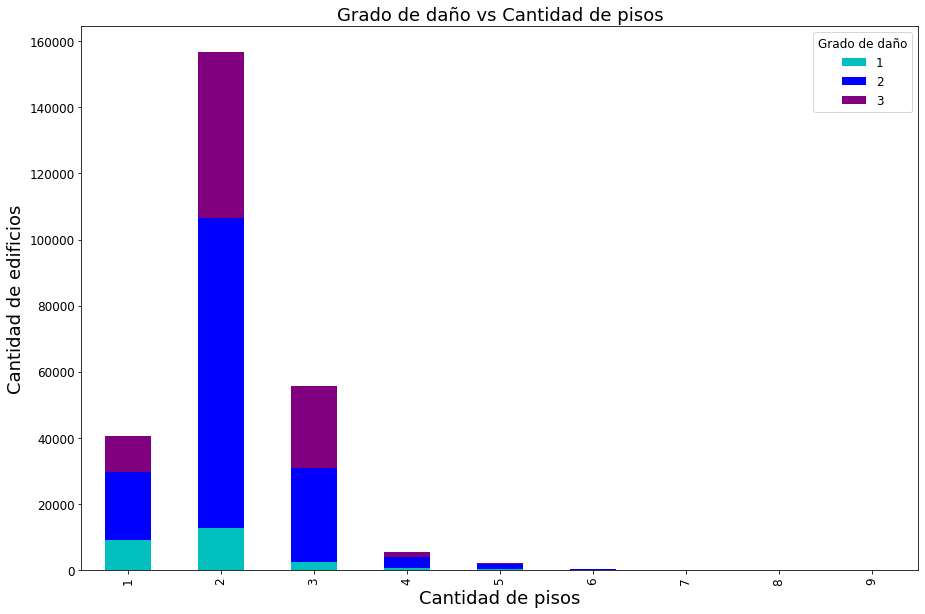

In [324]:
plot_damage_by_floors = damaged_buildings_floors_pivot.plot.bar(stacked=True, figsize=(15,10), color=['c', 'blue', 'purple'])
plot_damage_by_floors.set_title("Grado de daño vs Cantidad de pisos", fontsize=18)
plot_damage_by_floors.set_ylabel("Cantidad de edificios", fontsize=18)
plot_damage_by_floors.set_xlabel("Cantidad de pisos", fontsize=18)

Se puede observar que en general para todos los pisos, los edificios sufrieron más daños de nivel 2, y en segunda medida del nivel 3 (es decir que fueron completamente destruidos)

- Tomando los edificios con el mayor "piso" que fueron destruidos, es decir 2 pisos, veamos tambien que sucede con la antiguedad de ellos:

Text(0.5, 0, 'Antiguedad de los edificios')

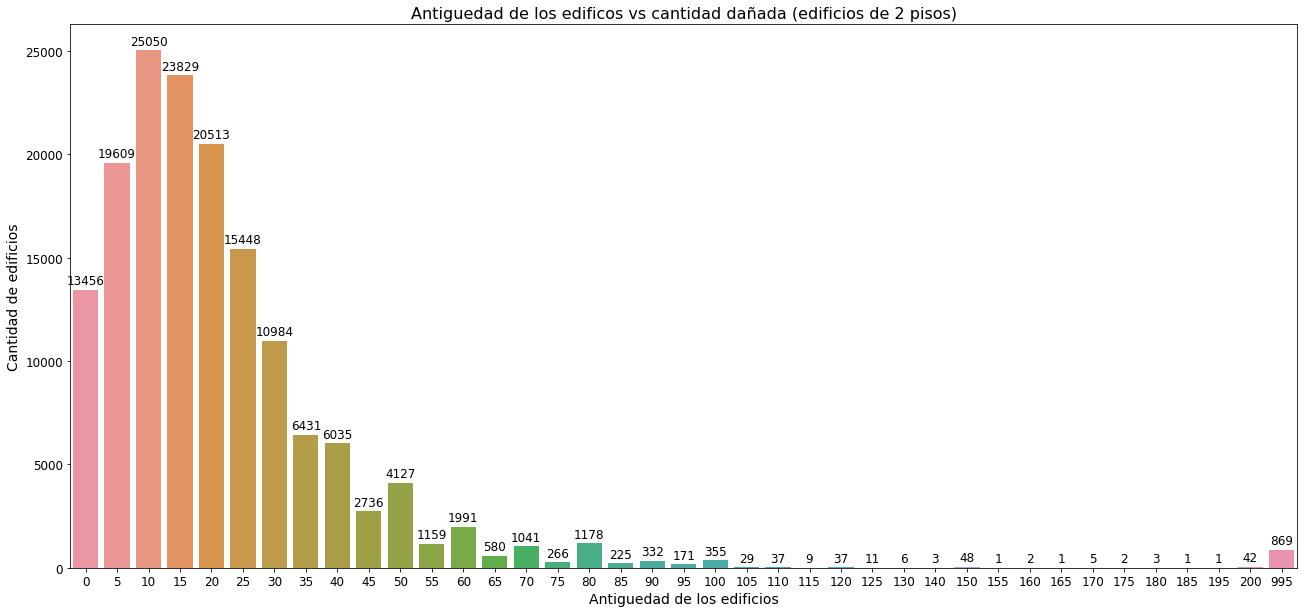

In [325]:
damaged_two_floors = train_values.loc[train_values['count_floors_pre_eq']==2, :]
target = damaged_two_floors['age'].value_counts()
plt.subplots(figsize=(22,10))
grafico=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico.patches:
    grafico.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico.set_title("Antiguedad de los edificos vs cantidad dañada (edificios de 2 pisos)",fontsize=16)
grafico.set_ylabel("Cantidad de edificios",fontsize=14)
grafico.set_xlabel("Antiguedad de los edificios",fontsize=14)

A grandes rasgos se puede observar que conserva la misma relación que el daño total, sin importar la cantidad de pisos. Los edificios de 10 años de antiguedad fueron los más dañados.

De la misma forma que en el inciso anterior, podemos ver para los edificios de 2 pisos, como se comporta el nivel de daño para cada uno de ellos

In [326]:
buildings_2_floors = damaged_two_floors.merge(train_labels).groupby(['age', 'damage_grade']).agg({'damage_grade':['count']})
buildings_2_floors

level0 = buildings_2_floors.columns.get_level_values(0)
level1 = buildings_2_floors.columns.get_level_values(1)
buildings_2_floors.columns = level0 + '_' + level1
buildings_2_floors.reset_index(inplace=True)
buildings_2_floors.rename(columns={'damage_grade':'Grado de daño'}, inplace=True)
buildings_2_floors

,age,Grado de daño,damage_grade_count
0,0,1,2589
1,0,2,7400
2,0,3,3467
3,5,1,2530
4,5,2,11765
...,...,...,...
94,200,2,20
95,200,3,20
96,995,1,121
97,995,2,509


In [327]:
damaged_buildings_2_floors_pivot = buildings_2_floors.pivot(index='age', columns='Grado de daño', values='damage_grade_count')

Text(0.5, 0, 'Antiguedad de los edificios')

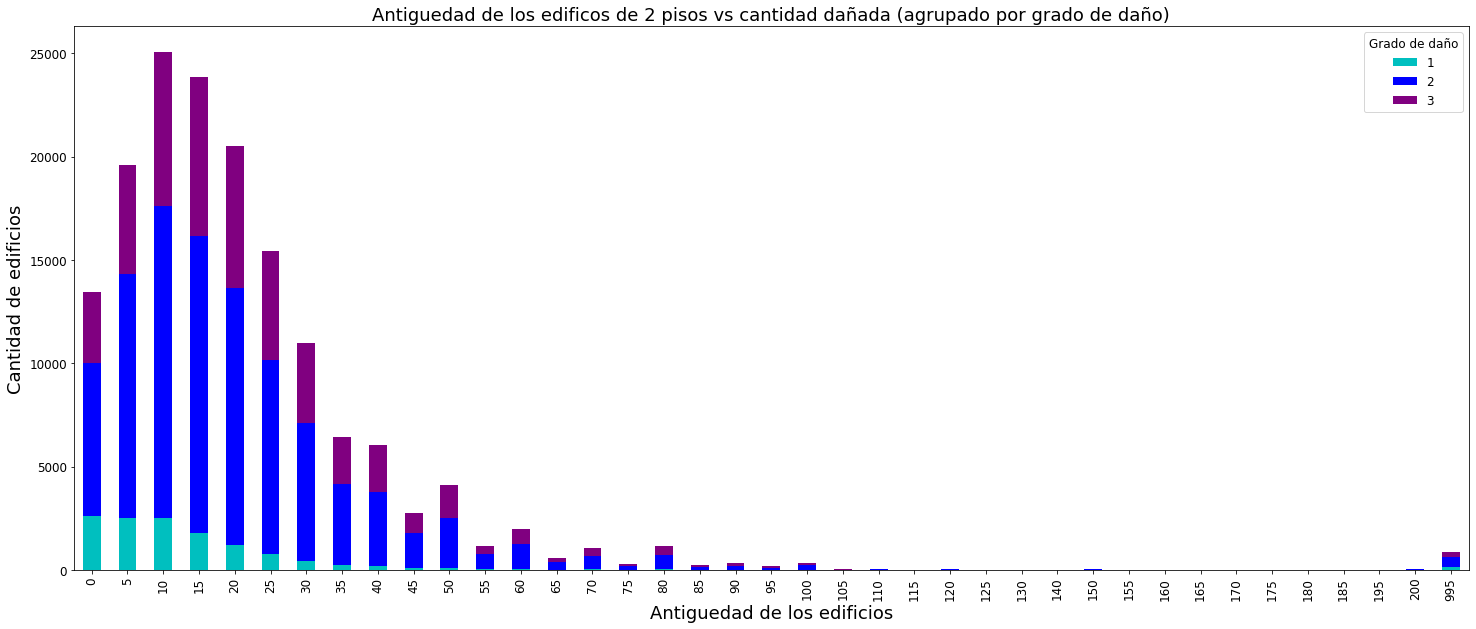

In [328]:
plot_2_floors = damaged_buildings_2_floors_pivot.plot.bar(stacked=True, figsize=(25,10), color=['c', 'blue', 'purple'])
plot_2_floors.set_title("Antiguedad de los edificos de 2 pisos vs cantidad dañada (agrupado por grado de daño)", fontsize=18)
plot_2_floors.set_ylabel("Cantidad de edificios", fontsize=18)
plot_2_floors.set_xlabel("Antiguedad de los edificios", fontsize=18)

Se observa que se mantiene la relación que los análisis anteriores, donde el mayor daño provocado es de nivel 2, seguido por el nivel 3.

# Condicion del suelo

Veamos como se distribuye la condición del suelo

In [329]:
train_values['land_surface_condition'].value_counts()

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64

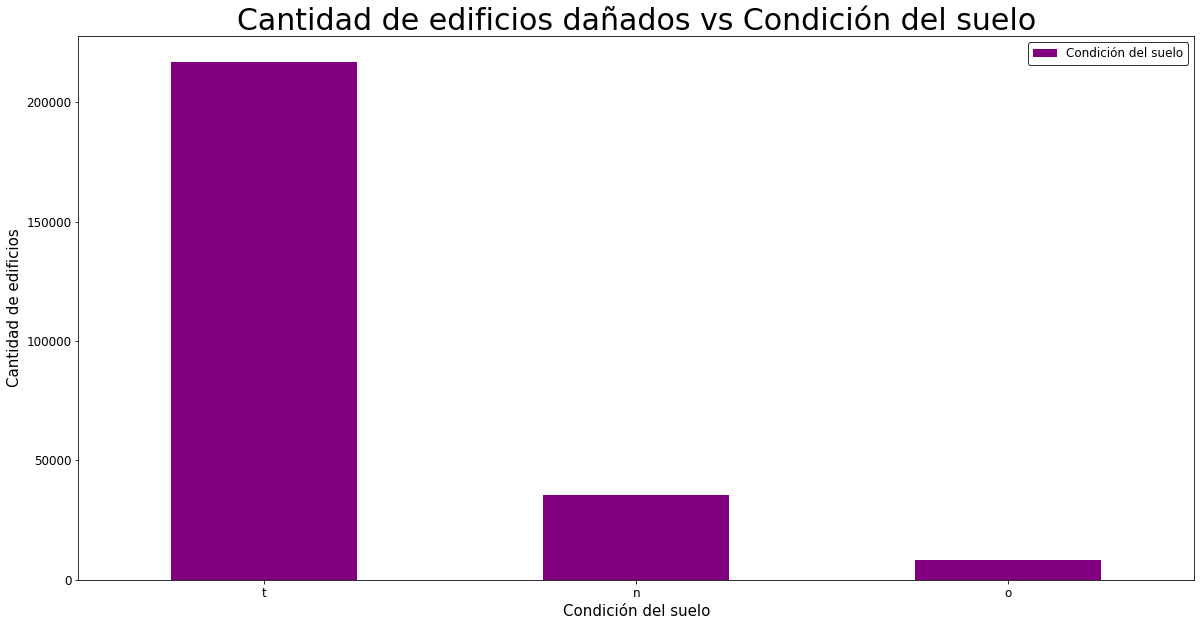

In [330]:
plot_condition=train_values['land_surface_condition'].value_counts().plot(kind='bar',color=['purple'], figsize=(20,10))
plt.xlabel("Condición del suelo", size=15)
plt.ylabel("Cantidad de edificios", size=15)
plt.legend(fancybox=True)
plt.xticks(rotation=0)
plt.title("Cantidad de edificios dañados vs Condición del suelo", size = 30)
leyenda=plt.legend(['Condición del suelo'],frameon=True,facecolor='white',edgecolor='black')

Si bien son valores categoricos, donde se desconoce el real significado de cada uno, podemos ver que la condición t es la que mayor cantidad de edificios tienen

Veamos entonces como se distribuyen los niveles de daño para las distintas condiciones del piso

In [331]:
buildings_by_surface_cond = buildings_with_damage.groupby(['land_surface_condition', 'damage_grade']).agg({'damage_grade':['count']})
level0 = buildings_by_surface_cond.columns.get_level_values(0)
level1 = buildings_by_surface_cond.columns.get_level_values(1)
buildings_by_surface_cond.columns = level0 + '_' + level1
buildings_by_surface_cond.reset_index(inplace=True)
buildings_by_surface_cond.rename(columns={'damage_grade':'Grado de daño'}, inplace=True)
buildings_by_surface_cond.head()

,land_surface_condition,Grado de daño,damage_grade_count
0,n,1,2556
1,n,2,21484
2,n,3,11488
3,o,1,602
4,o,2,4708


In [332]:
bulding_by_surface_pivot = buildings_by_surface_cond.pivot(index='land_surface_condition', columns='Grado de daño', values='damage_grade_count')

Text(0.5, 0, 'Condición del suelo')

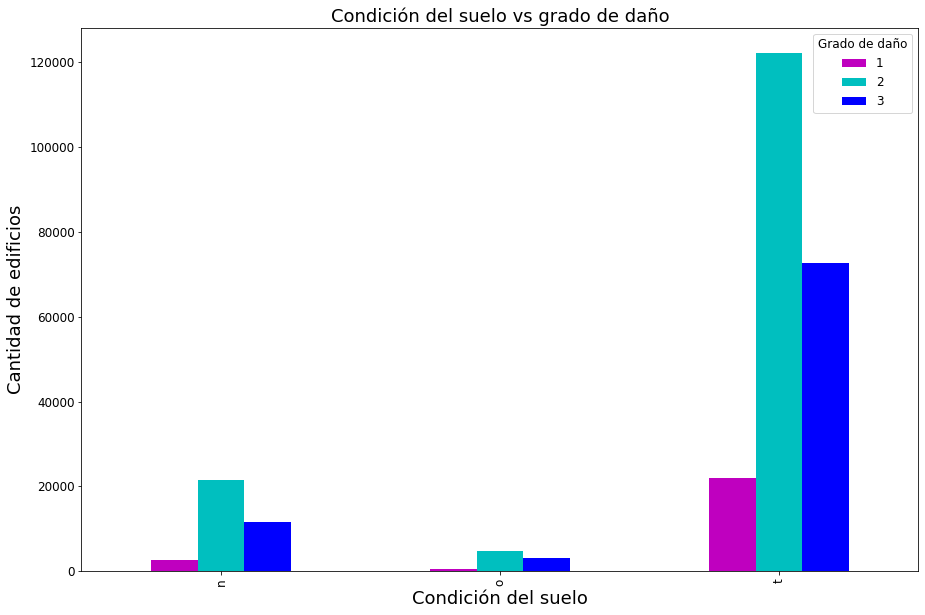

In [333]:
plot_surface = bulding_by_surface_pivot.plot.bar(stacked=False, figsize=(15,10), color=["m", "c", 'blue'])
plot_surface.set_title("Condición del suelo vs grado de daño", fontsize=18)
plot_surface.set_ylabel("Cantidad de edificios", fontsize=18)
plot_surface.set_xlabel("Condición del suelo", fontsize=18)

A simple vista se puede observar que la superficie que más daño tuvo fue la t, donde independientemente de la cantidad (en relación con los analisis anteriores) el porcentaje de edificios que fueron dañados con nivel 2 es superior para las distintas superficies, seguidas del nivel 3.

# Tipo de base

In [334]:
buildings_with_damage['foundation_type'].value_counts()

r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64

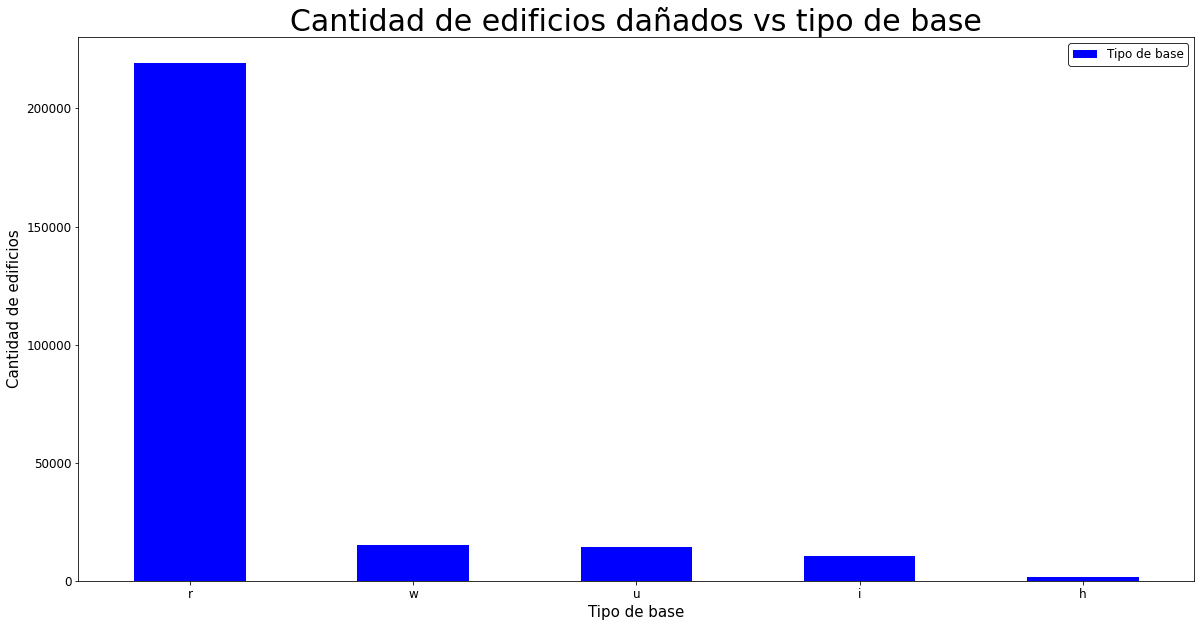

In [335]:
plot_condition=train_values['foundation_type'].value_counts().plot(kind='bar',color=['blue'], figsize=(20,10))
plt.xlabel("Tipo de base", size=15)
plt.ylabel("Cantidad de edificios", size=15)
plt.legend(fancybox=True)
plt.xticks(rotation=0)
plt.title("Cantidad de edificios dañados vs tipo de base", size = 30)
leyenda=plt.legend(['Tipo de base'],frameon=True,facecolor='white',edgecolor='black')

De la misma forma, siendo valores categóricos, podemos ver que el tipo de base r fue el que más daño sufrió

Veamos entonces como se distribuyen los niveles de daño para las distintas bases

In [336]:
buildings_by_foundation_type = buildings_with_damage.groupby(['foundation_type', 'damage_grade']).agg({'damage_grade':['count']})
level0 = buildings_by_foundation_type.columns.get_level_values(0)
level1 = buildings_by_foundation_type.columns.get_level_values(1)
buildings_by_foundation_type.columns = level0 + '_' + level1
buildings_by_foundation_type.reset_index(inplace=True)
buildings_by_foundation_type.rename(columns={'damage_grade':'Grado_de_daño'}, inplace=True)
buildings_by_foundation_type.head()

,foundation_type,Grado_de_daño,damage_grade_count
0,h,1,358
1,h,2,579
2,h,3,511
3,i,1,6004
4,i,2,4354


In [337]:
bulding_by_foundation_pivot = buildings_by_foundation_type.pivot(index='foundation_type', columns='Grado_de_daño', values='damage_grade_count')

Text(0.5, 0, 'Tipo de base')

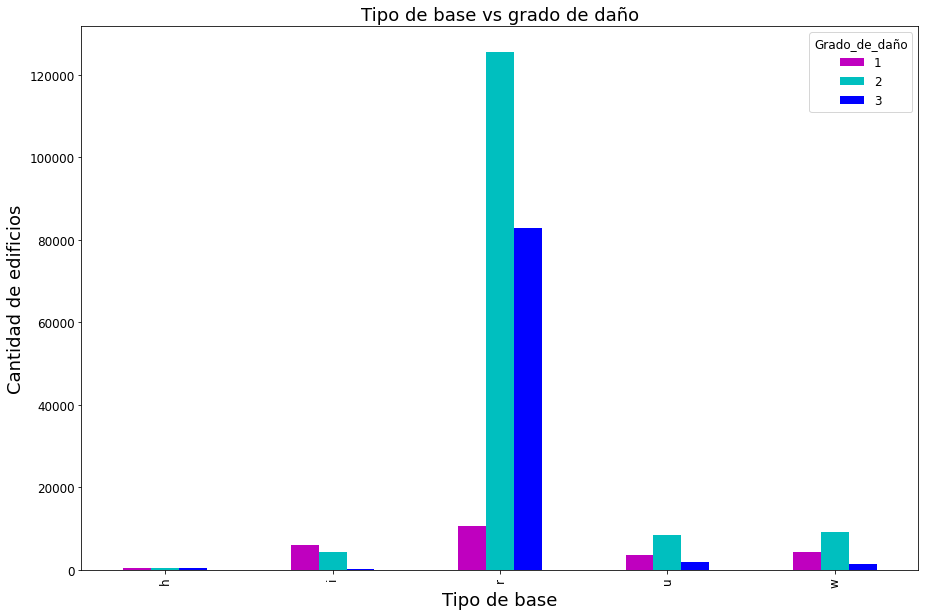

In [338]:
plot_foundation = bulding_by_foundation_pivot.plot.bar(stacked=False, figsize=(15,10), color=["m", "c", 'blue'])
plot_foundation.set_title("Tipo de base vs grado de daño", fontsize=18)
plot_foundation.set_ylabel("Cantidad de edificios", fontsize=18)
plot_foundation.set_xlabel("Tipo de base", fontsize=18)

Con este gráfico se puede ver algo interesante:

La base r fue la que más destrucciones sufrió, siguiendo una relación que venimos viendo que la mayoría es del daño sufrido es de nivel 2, seguido por destrucción total y finalmente daño menor.

Pero se puede observar que para la base i la mayoria de los edificios dañados fueron de nivel 1, lo que supone que este tipo de base fue más resistente a los daños ocasionados por el terremoto. También le siguen los daños de nivel 2, y la cantidad de edificios destruidos por completo fue muy reducida.

Veamos un poco más en detalle:

In [339]:
buildings_foundation_i = buildings_by_foundation_type.loc[buildings_by_foundation_type['foundation_type']=='i', :]
buildings_foundation_i['damaged_percentage'] = ((buildings_foundation_i['damage_grade_count'] / buildings_foundation_i['damage_grade_count'].sum() * 100)).astype(int)

buildings_foundation_i

,foundation_type,Grado_de_daño,damage_grade_count,damaged_percentage
3,i,1,6004,56
4,i,2,4354,41
5,i,3,221,2


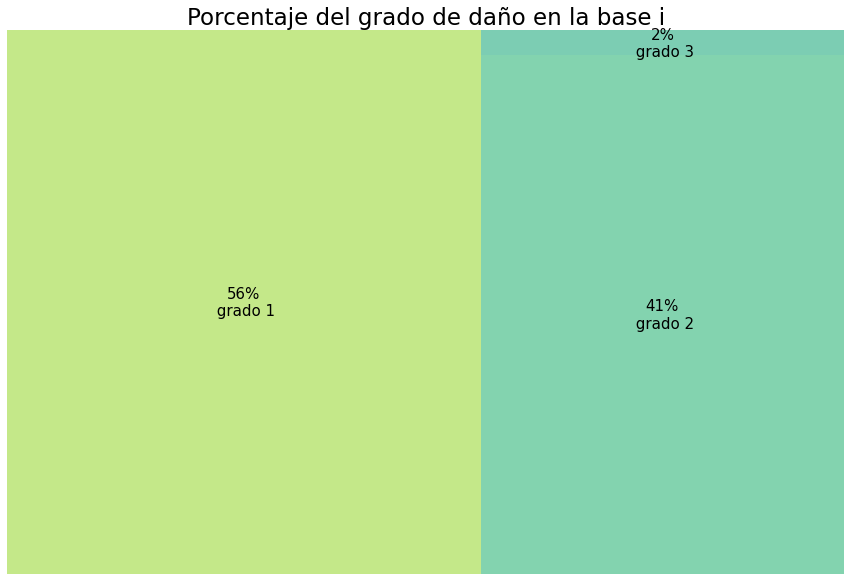

In [340]:
labels_foundations = [f'{damaged_percentage}%\n grado {Grado_de_daño}' for damaged_percentage, Grado_de_daño in \
                      zip(buildings_foundation_i.damaged_percentage, buildings_foundation_i.Grado_de_daño)]

plt.figure(figsize=(15, 10))
plt.rc('font', size=12)
squarify.plot(sizes=buildings_foundation_i['damaged_percentage'], label=labels_foundations, alpha=0.6, text_kwargs={'fontsize':15})

plt.title("Porcentaje del grado de daño en la base i",fontsize=23)
plt.axis('off')
plt.show()

De esta forma se puede observar con más claridad: Un 56% de los edificios con base tipo i sufrieron daños de grado 1, y tan solo el 2% fueron destruidos completamente, equivalentes a 221 edificios.

De una forma similar, para tener una comparación más clara sobre el porcentaje en cada uno de los tipos de base, podemos realizar el mismo gráfico anterior pero utilizando la escala logarítmica.

De esta forma, los valores estan "parcialmente normalizados" y podemos visualizar todos los mismos datos en una escala más similar, sin importar la diferencia de cantidad

Text(0.5, 0, 'Tipo de base')

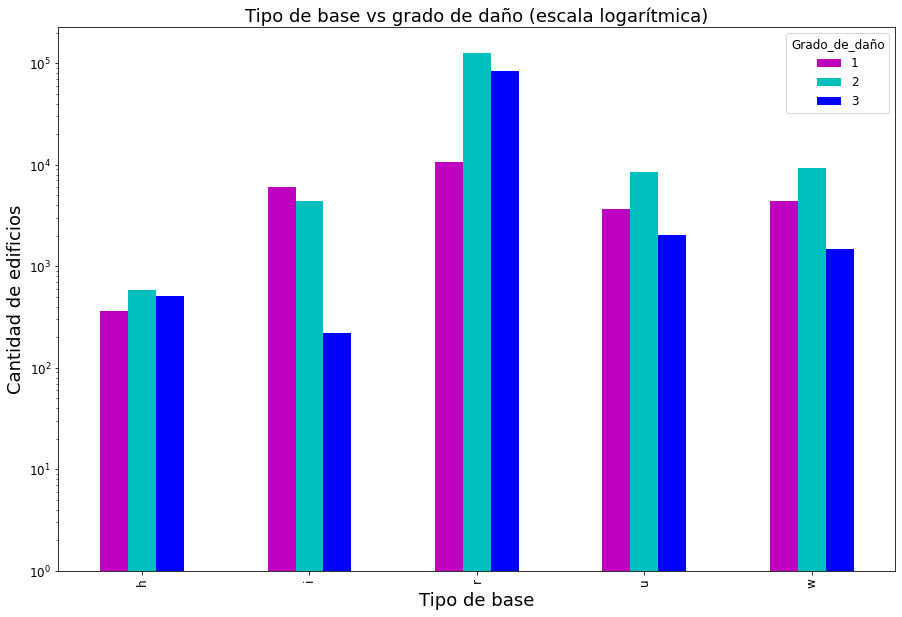

In [341]:
plot_foundation_log = bulding_by_foundation_pivot.plot.bar(stacked=False, figsize=(15,10), color=["m", "c", 'blue'], log=True)
plot_foundation_log.set_title("Tipo de base vs grado de daño (escala logarítmica)", fontsize=18)
plot_foundation_log.set_ylabel("Cantidad de edificios", fontsize=18)
plot_foundation_log.set_xlabel("Tipo de base", fontsize=18)

Con este gráfico nos podemos dar una noción más clara para todos los tipos de base como se comportó el grado de daño, sin importar la cantidad:

Como se mencionó anteriormente, la base i fue la que mejor resistió al terremoto. De los edificios que daño, ocasionó el menor daño posible, de nivel 1 y de nivel 2.

Las bases r y h fueron las que, de la cantidad de edificios dañados, más sufrieron dañado, ya que principalmente se ocasiaron daños de nivel 2, seguido de una destrucción total.

En su contraparte, las bases u y w sufrieron principalmente daños de nivel 2, seguido de daños de nivel 1.

# Tipo de techo

In [342]:
train_values_filtered_with_damage_grade = train_values[['building_id','roof_type','ground_floor_type','other_floor_type','plan_configuration']].merge(train_labels,on='building_id', how='inner')
train_values_filtered_with_damage_grade.head()

,building_id,roof_type,ground_floor_type,other_floor_type,plan_configuration,damage_grade
0,802906,n,f,q,d,3
1,28830,n,x,q,d,2
2,94947,n,f,x,d,3
3,590882,n,f,x,d,2
4,201944,n,f,x,d,3


In [343]:
avg_damage_roof_type = train_values_filtered_with_damage_grade.groupby('roof_type').agg({'damage_grade':'mean','building_id':'count'})
avg_damage_roof_type['percentage'] = np.round((avg_damage_roof_type['building_id']/buildings_count)*100,decimals=1)
avg_damage_roof_type

,damage_grade,building_id,percentage
roof_type,,,
n,2.269637,182842,70.2
q,2.320173,61576,23.6
x,1.572267,16183,6.2


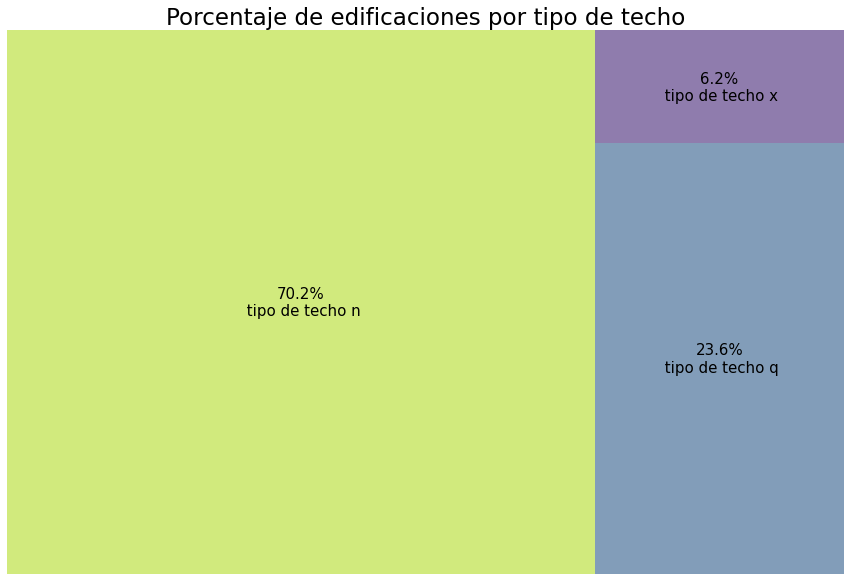

In [344]:
labels_foundations = [f'{percentage}%\n tipo de techo {index}' for  percentage, index in \
                      zip(avg_damage_roof_type.percentage, avg_damage_roof_type.index)]

plt.figure(figsize=(15, 10))
plt.rc('font', size=12)
squarify.plot(sizes=avg_damage_roof_type['percentage'], label=labels_foundations, alpha=0.61, text_kwargs={'fontsize':15})

plt.title("Porcentaje de edificaciones por tipo de techo",fontsize=23)
plt.axis('off')
plt.show()

Text(0.5, 0, 'Tipo de techo')

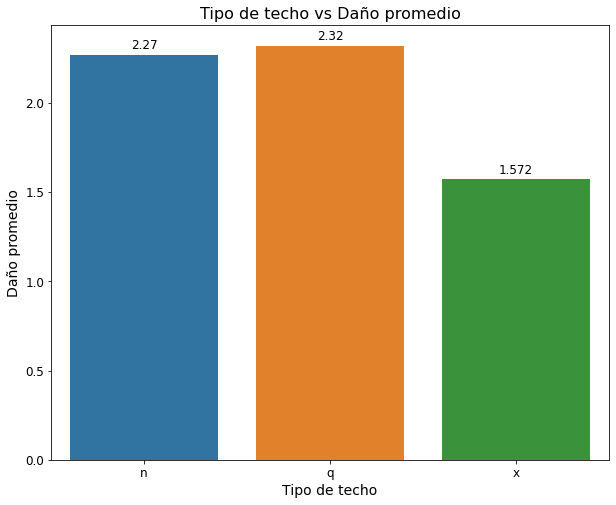

In [345]:
target = avg_damage_roof_type['damage_grade']
plt.subplots(figsize=(10,8))
grafico=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico.patches:
    grafico.annotate(str(np.round(p.get_height(),decimals=3)),  (p.get_x() + p.get_width() / 2  , p.get_height()),ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico.set_title("Tipo de techo vs Daño promedio",fontsize=16)
grafico.set_ylabel("Daño promedio",fontsize=14)
grafico.set_xlabel("Tipo de techo",fontsize=14)

In [346]:
count_buildings_by_damage_roof_type =\
 train_values_filtered_with_damage_grade.rename(columns={'damage_grade':'Grado de daño'}).groupby(['roof_type','Grado de daño']).agg({'building_id':'count'}).reset_index()
count_buildings_by_damage_roof_type_pivot=count_buildings_by_damage_roof_type.pivot(index='roof_type', columns='Grado de daño', values='building_id')
count_buildings_by_damage_roof_type_pivot

Grado de daño,1,2,3
roof_type,,,
n,13547,106447,62848
q,3926,34009,23641
x,7651,7803,729


Text(0.5, 0, 'Tipo de techo')

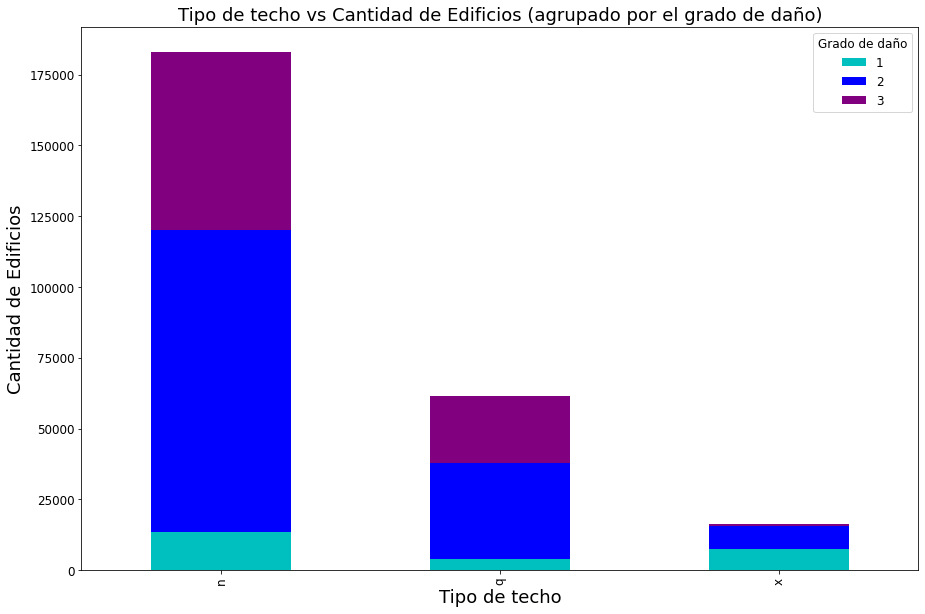

In [347]:
plot_damage_by_roof_type = count_buildings_by_damage_roof_type_pivot.plot.bar(stacked=True, figsize=(15,10), color=['c', 'blue', 'purple'])
plot_damage_by_roof_type.set_title("Tipo de techo vs Cantidad de Edificios (agrupado por el grado de daño)", fontsize=18)
plot_damage_by_roof_type.set_ylabel("Cantidad de Edificios", fontsize=18)
plot_damage_by_roof_type.set_xlabel("Tipo de techo", fontsize=18)

# Tipo de suelo en planta baja

In [348]:
avg_damage_ground_floor_type = train_values_filtered_with_damage_grade.groupby('ground_floor_type').agg({'damage_grade':'mean','building_id':'count'})
avg_damage_ground_floor_type['percentage'] = np.round((avg_damage_ground_floor_type['building_id']/buildings_count)*100,decimals=1)
avg_damage_ground_floor_type

,damage_grade,building_id,percentage
ground_floor_type,,,
f,2.309104,209619,80.4
m,1.970472,508,0.2
v,1.634205,24593,9.4
x,2.250714,24877,9.5
z,2.073705,1004,0.4


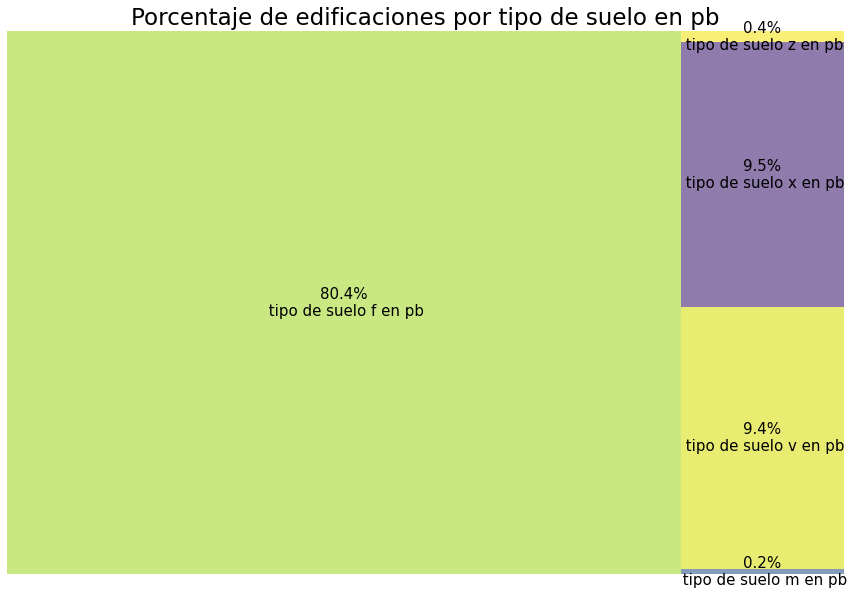

In [349]:
labels_foundations = [f'{percentage}%\n tipo de suelo {index} en pb' for  percentage, index in \
                      zip(avg_damage_ground_floor_type.percentage, avg_damage_ground_floor_type.index)]

plt.figure(figsize=(15, 10))
plt.rc('font', size=12)
squarify.plot(sizes=avg_damage_ground_floor_type['percentage'], label=labels_foundations, alpha=0.61, text_kwargs={'fontsize':15})

plt.title("Porcentaje de edificaciones por tipo de suelo en pb",fontsize=23)
plt.axis('off')
plt.show()

Text(0.5, 0, 'Tipo de suelo en plata baja')

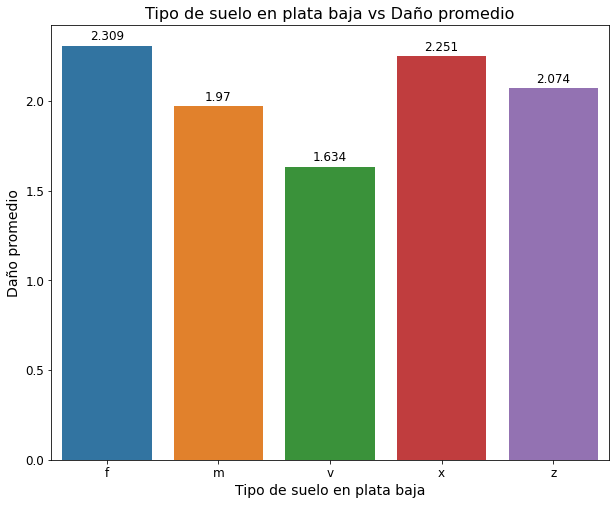

In [350]:
target = avg_damage_ground_floor_type['damage_grade']
plt.subplots(figsize=(10,8))
grafico=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico.patches:
    grafico.annotate(str(np.round(p.get_height(),decimals=3)),  (p.get_x() + p.get_width() / 2  , p.get_height()),ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico.set_title("Tipo de suelo en plata baja vs Daño promedio",fontsize=16)
grafico.set_ylabel("Daño promedio",fontsize=14)
grafico.set_xlabel("Tipo de suelo en plata baja",fontsize=14)

In [351]:
count_buildings_by_ground_floor_type =\
 train_values_filtered_with_damage_grade.rename(columns={'damage_grade':'Grado de daño'}).groupby(['ground_floor_type','Grado de daño']).agg({'building_id':'count'}).reset_index()
count_buildings_by_ground_floor_type_pivot=count_buildings_by_ground_floor_type.pivot(index='ground_floor_type', columns='Grado de daño', values='building_id')
count_buildings_by_ground_floor_type_pivot

Grado de daño,1,2,3
ground_floor_type,,,
f,12474,119877,77268
m,90,343,75
v,10309,12971,1313
x,2052,14536,8289
z,199,532,273


Text(0.5, 0, 'Tipo de suelo en plata baja')

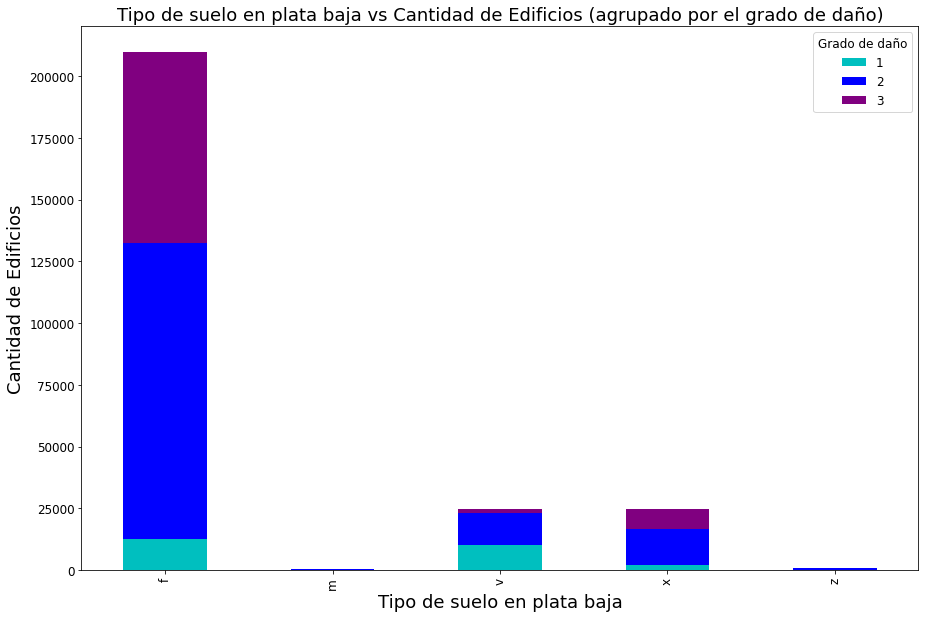

In [352]:
plot_damage_by_ground_floor_type = count_buildings_by_ground_floor_type_pivot.plot.bar(stacked=True, figsize=(15,10), color=['c', 'blue', 'purple'])
plot_damage_by_ground_floor_type.set_title("Tipo de suelo en plata baja vs Cantidad de Edificios (agrupado por el grado de daño)", fontsize=18)
plot_damage_by_ground_floor_type.set_ylabel("Cantidad de Edificios", fontsize=18)
plot_damage_by_ground_floor_type.set_xlabel("Tipo de suelo en plata baja", fontsize=18)

# Tipo de suelo en otros pisos

In [353]:
avg_damage_other_floor_type = train_values_filtered_with_damage_grade.groupby('other_floor_type').agg({'damage_grade':'mean','building_id':'count'})
avg_damage_other_floor_type['percentage'] = np.round((avg_damage_other_floor_type['building_id']/buildings_count)*100, decimals=1)
avg_damage_other_floor_type

,damage_grade,building_id,percentage
other_floor_type,,,
j,2.042893,39843,15.3
q,2.315751,165282,63.4
s,1.607416,12028,4.6
x,2.297344,43448,16.7


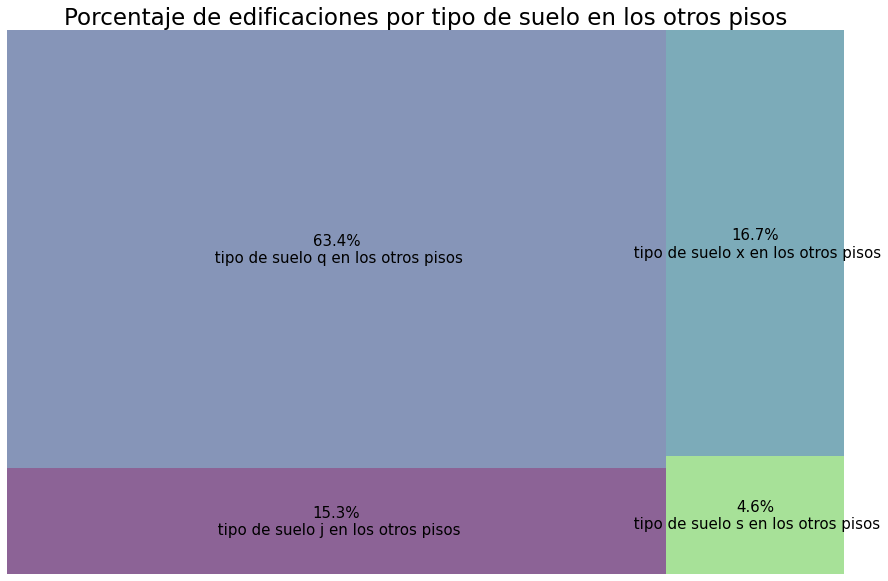

In [354]:
labels_foundations = [f'{percentage}%\n tipo de suelo {index} en los otros pisos' for  percentage, index in \
                      zip(avg_damage_other_floor_type.percentage, avg_damage_other_floor_type.index)]

plt.figure(figsize=(15, 10))
plt.rc('font', size=12)
squarify.plot(sizes=avg_damage_other_floor_type['percentage'], label=labels_foundations, alpha=0.61, text_kwargs={'fontsize':15})

plt.title("Porcentaje de edificaciones por tipo de suelo en los otros pisos",fontsize=23)
plt.axis('off')
plt.show()

Text(0.5, 0, 'Tipo de suelo para otros pisos')

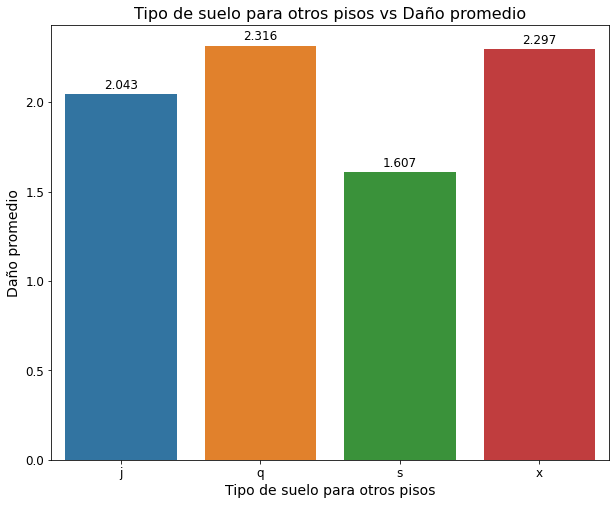

In [355]:
target = avg_damage_other_floor_type['damage_grade']
plt.subplots(figsize=(10,8))
grafico=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico.patches:
    grafico.annotate(str(np.round(p.get_height(),decimals=3)),  (p.get_x() + p.get_width() / 2  , p.get_height()),ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico.set_title("Tipo de suelo para otros pisos vs Daño promedio",fontsize=16)
grafico.set_ylabel("Daño promedio",fontsize=14)
grafico.set_xlabel("Tipo de suelo para otros pisos",fontsize=14)

In [356]:
count_buildings_by_damage_other_floor_type =\
 train_values_filtered_with_damage_grade.rename(columns={'damage_grade':'Grado de daño'}).groupby(['other_floor_type','Grado de daño']).agg({'building_id':'count'}).reset_index()
count_buildings_by_damage_other_floor_type_pivot=count_buildings_by_damage_other_floor_type.pivot(index='other_floor_type', columns='Grado de daño', values='building_id')
count_buildings_by_damage_other_floor_type_pivot

Grado de daño,1,2,3
other_floor_type,,,
j,8886,20362,10595
q,7387,98320,59575
s,5423,5904,701
x,3428,23673,16347


Text(0.5, 0, 'Tipo de suelo para otros pisos')

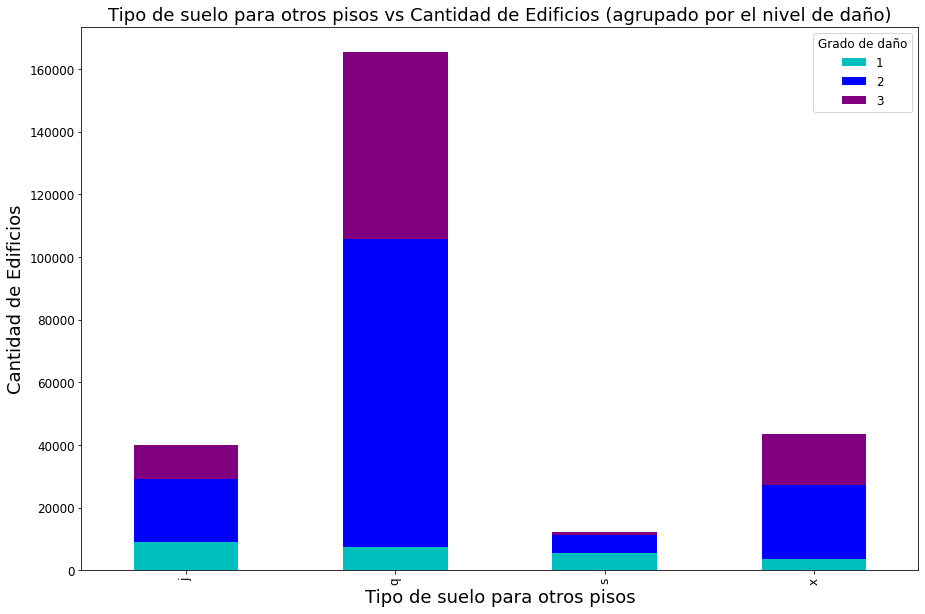

In [357]:
plot_damage_by_other_floor_type = count_buildings_by_damage_other_floor_type_pivot.plot.bar(stacked=True, figsize=(15,10), color=['c', 'blue', 'purple'])
plot_damage_by_other_floor_type.set_title("Tipo de suelo para otros pisos vs Cantidad de Edificios (agrupado por el nivel de daño)", fontsize=18)
plot_damage_by_other_floor_type.set_ylabel("Cantidad de Edificios", fontsize=18)
plot_damage_by_other_floor_type.set_xlabel("Tipo de suelo para otros pisos", fontsize=18)

In [358]:
avg_damage_plan_configuration = train_values_filtered_with_damage_grade.groupby('plan_configuration').agg({'damage_grade':'mean','building_id':'count'})
avg_damage_plan_configuration['percentage'] = np.round((avg_damage_plan_configuration['building_id']/buildings_count)*100,decimals=2)
avg_damage_plan_configuration

,damage_grade,building_id,percentage
plan_configuration,,,
a,1.853175,252,0.10
c,1.836923,325,0.12
d,2.243646,250072,95.96
f,2.272727,22,0.01
m,1.913043,46,0.02
n,2.157895,38,0.01
o,1.893082,159,0.06
q,2.271434,5692,2.18
s,2.049133,346,0.13


# Formato de construccion

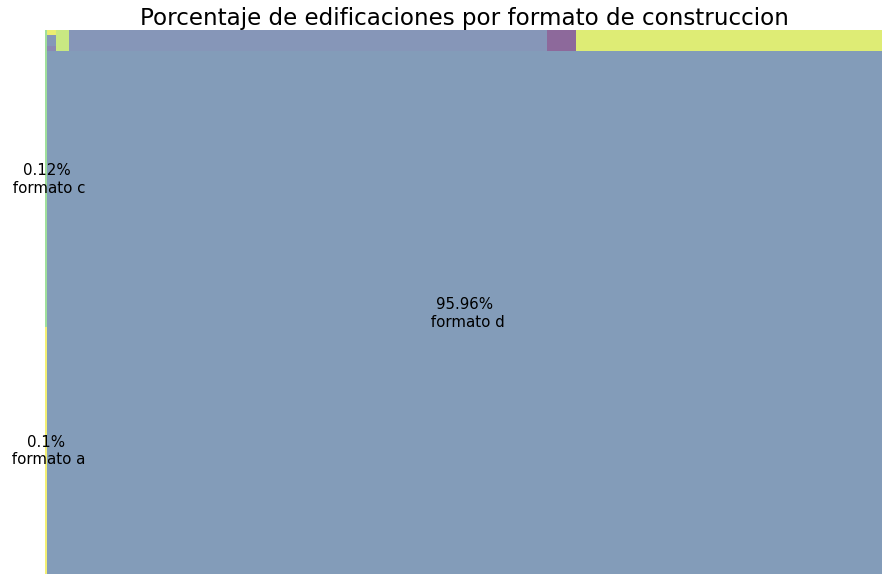

In [359]:
labels_foundations = [f'{percentage}%\n formato {index}' for  percentage, index in \
                      zip(avg_damage_plan_configuration.percentage, avg_damage_plan_configuration.index)]

plt.figure(figsize=(15, 10))
plt.rc('font', size=12)
squarify.plot(sizes=avg_damage_plan_configuration['percentage'], label=labels_foundations[:3], alpha=0.61, text_kwargs={'fontsize':15})

plt.title("Porcentaje de edificaciones por formato de construccion",fontsize=23)
plt.axis('off')
plt.show()

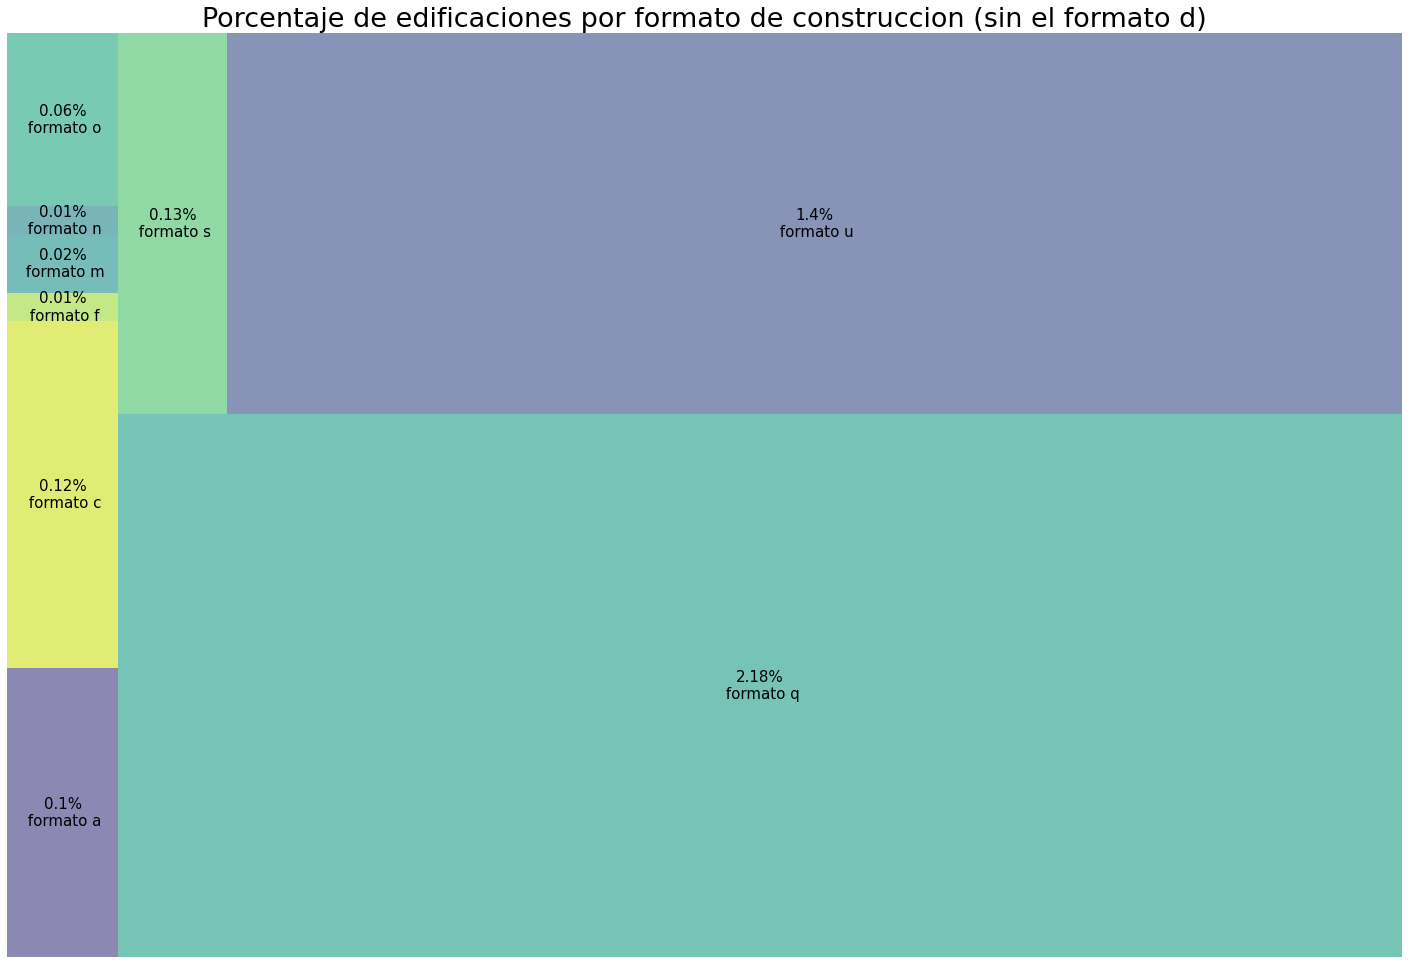

In [360]:
avg_damage_plan_configuration_without_config_d =\
  avg_damage_plan_configuration[avg_damage_plan_configuration.index != 'd']

labels_foundations = [f'{percentage}%\n formato {index}' for  percentage, index in \
                      zip(avg_damage_plan_configuration_without_config_d.percentage, avg_damage_plan_configuration_without_config_d.index)]

plt.figure(figsize=(25, 17))
plt.rc('font', size=12)
squarify.plot(sizes=avg_damage_plan_configuration_without_config_d['percentage'], label=labels_foundations, alpha=0.61, text_kwargs={'fontsize':15})

plt.title("Porcentaje de edificaciones por formato de construccion (sin el formato d)",fontsize=27)
plt.axis('off')
plt.show()

Text(0.5, 0, 'Formato de construccion')

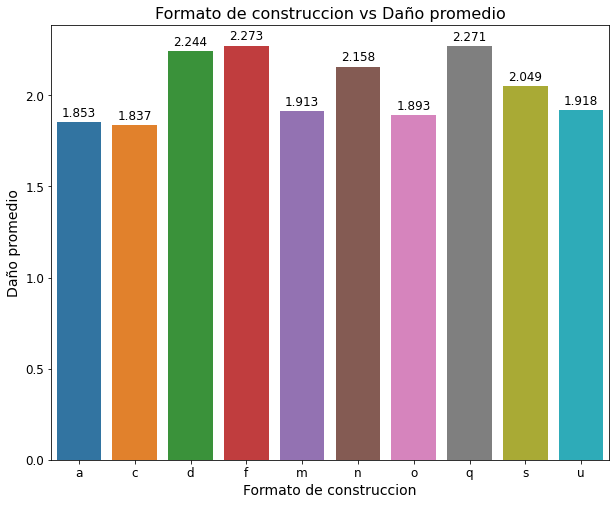

In [361]:
target = avg_damage_plan_configuration['damage_grade'] 
plt.subplots(figsize=(10,8))
grafico=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico.patches:
    grafico.annotate(str(np.round(p.get_height(),decimals=3)),  (p.get_x() + p.get_width() / 2  , p.get_height()),ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico.set_title("Formato de construccion vs Daño promedio",fontsize=16)
grafico.set_ylabel("Daño promedio",fontsize=14)
grafico.set_xlabel("Formato de construccion",fontsize=14)

In [362]:
buildings_with_d_plan_config =\
  train_values_filtered_with_damage_grade[train_values_filtered_with_damage_grade['plan_configuration']=='d']
percent_of_d_plan_config_buildings = (buildings_with_d_plan_config['plan_configuration'].count()/train_values_filtered_with_damage_grade['plan_configuration'].count()) * 100
percent_of_d_plan_config_buildings

95.95972386905652

In [363]:
count_buildings_by_damage_plan_configuration =\
 train_values_filtered_with_damage_grade.rename(columns={'damage_grade':'Grado de daño'}).groupby(['plan_configuration','Grado de daño']).agg({'building_id':'count'}).reset_index()
count_buildings_by_damage_plan_configuration_pivot=count_buildings_by_damage_plan_configuration.pivot(index='plan_configuration', columns='Grado de daño', values='building_id')
count_buildings_by_damage_plan_configuration_pivot

Grado de daño,1,2,3
plan_configuration,,,
a,66.0,157.0,29.0
c,86.0,206.0,33.0
d,23310.0,142523.0,84239.0
f,NaN,16.0,6.0
m,8.0,34.0,4.0
n,6.0,20.0,12.0
o,40.0,96.0,23.0
q,781.0,2585.0,2326.0
s,53.0,223.0,70.0


Text(0.5, 0, 'Formato de construccion')

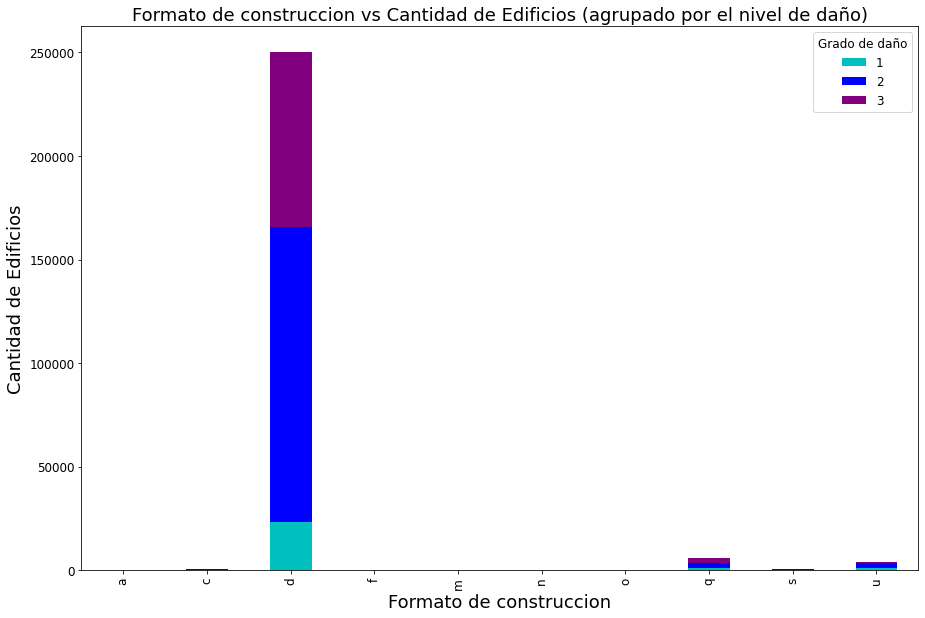

In [364]:
plot_damage_by_plan_configuration = count_buildings_by_damage_plan_configuration_pivot.plot.bar(stacked=True, figsize=(15,10), color=['c', 'blue', 'purple'])
plot_damage_by_plan_configuration.set_title("Formato de construccion vs Cantidad de Edificios (agrupado por el nivel de daño)", fontsize=18)
plot_damage_by_plan_configuration.set_ylabel("Cantidad de Edificios", fontsize=18)
plot_damage_by_plan_configuration.set_xlabel("Formato de construccion", fontsize=18)

In [365]:
buildings_without_d_plan_config =\
  train_values_filtered_with_damage_grade[train_values_filtered_with_damage_grade['plan_configuration']!='d']
count_buildings_by_damage_plan_configuration_without_d =\
 buildings_without_d_plan_config.rename(columns={'damage_grade':'Grado de daño'}).groupby(['plan_configuration','Grado de daño']).agg({'building_id':'count'}).reset_index()
count_buildings_by_damage_plan_configuration_without_d_pivot=count_buildings_by_damage_plan_configuration_without_d.pivot(index='plan_configuration', columns='Grado de daño', values='building_id')
count_buildings_by_damage_plan_configuration_without_d_pivot

Grado de daño,1,2,3
plan_configuration,,,
a,66.0,157.0,29.0
c,86.0,206.0,33.0
f,NaN,16.0,6.0
m,8.0,34.0,4.0
n,6.0,20.0,12.0
o,40.0,96.0,23.0
q,781.0,2585.0,2326.0
s,53.0,223.0,70.0
u,774.0,2399.0,476.0


Text(0.5, 0, 'Formato de construccion')

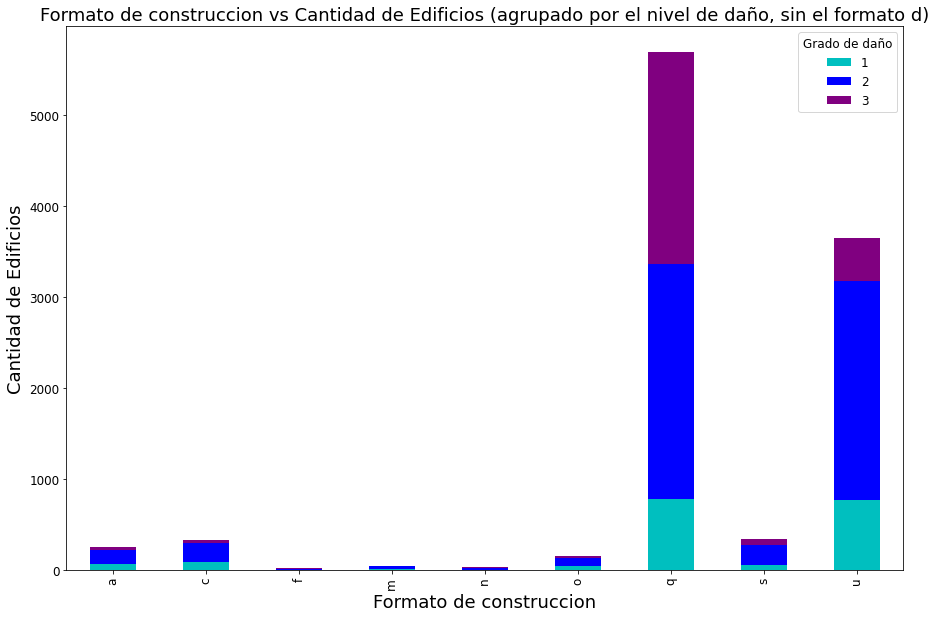

In [366]:
plot_damage_by_plan_configuration = count_buildings_by_damage_plan_configuration_without_d_pivot.plot.bar(stacked=True, figsize=(15,10), color=['c', 'blue', 'purple'])
plot_damage_by_plan_configuration.set_title("Formato de construccion vs Cantidad de Edificios (agrupado por el nivel de daño, sin el formato d)", fontsize=18)
plot_damage_by_plan_configuration.set_ylabel("Cantidad de Edificios", fontsize=18)
plot_damage_by_plan_configuration.set_xlabel("Formato de construccion", fontsize=18)

# Materiales de construccion

Queremos poder analizar como afecto los materiales que se utilizaron para cada construccion con respecto al posterior daño recibido por el terremoto

In [367]:
buildings_with_damage

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
260597,669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
260598,602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
260599,151409,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2


In [368]:
col_rename1 = {'has_superstructure_adobe_mud':'adobe_barro','has_superstructure_mud_mortar_stone':'adobe_piedra','has_superstructure_stone_flag':'piedra',\
              'has_superstructure_cement_mortar_stone':'cemento_piedra','has_superstructure_mud_mortar_brick':'barro_ladrillos','has_superstructure_cement_mortar_brick':'madera_para_construccion',\
              'has_superstructure_timber':'madera_para_construccion','has_superstructure_bamboo':'bambu','has_superstructure_rc_non_engineered':'concreto_reforzado_no_diseñado','has_superstructure_rc_engineered':'concreto_reforzado_diseñado',\
              'has_superstructure_other':'otro'}
materials = buildings_with_damage.rename(columns= col_rename1).iloc[:,15:26]

materials_vs_damage_mean = materials.apply(lambda x: np.asarray(x) * np.asarray(buildings_with_damage['damage_grade']))\
                              .apply(lambda x: x.replace(0, np.NaN))\
                              .apply(lambda x: np.asarray(x.dropna()).mean())

col_rename2 = {0:'damage_grade'}
materials_vs_damage_mean_df = materials_vs_damage_mean.to_frame().rename(columns= col_rename2)
materials_vs_damage_mean_df = materials_vs_damage_mean_df.sort_values('damage_grade',ascending=False)

materials_vs_damage_mean_df

,damage_grade
piedra,2.452554
adobe_barro,2.346782
adobe_piedra,2.337901
barro_ladrillos,2.271212
madera_para_construccion,2.165222
bambu,2.111718
otro,2.088348
cemento_piedra,1.967593
concreto_reforzado_no_diseñado,1.779530
madera_para_construccion,1.693296


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

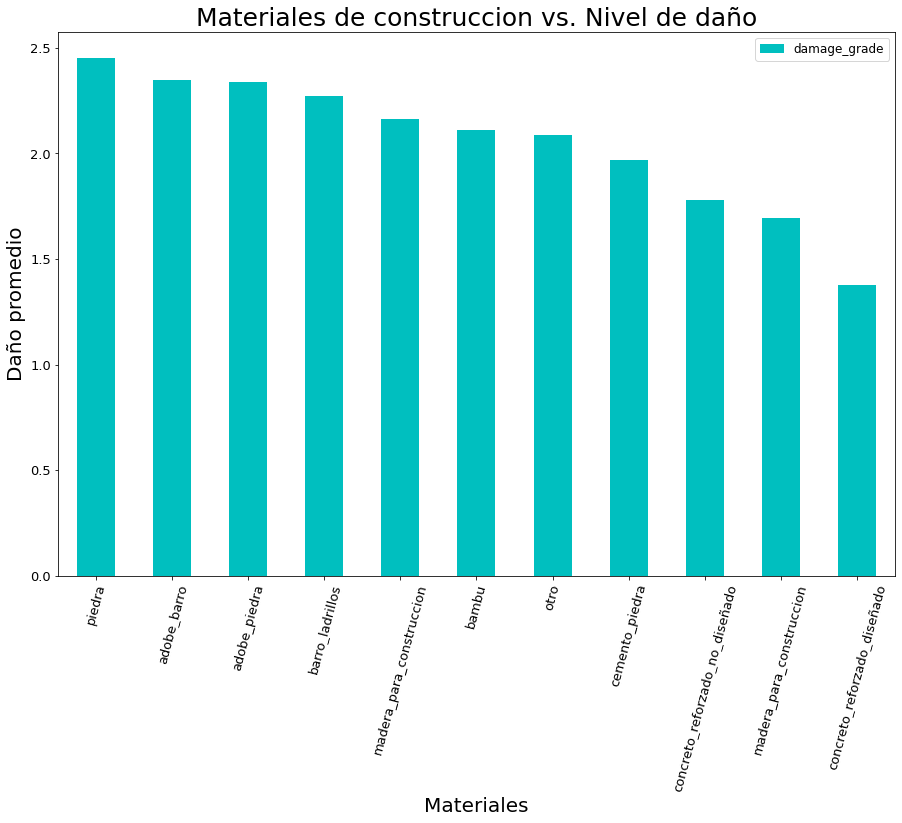

In [369]:
materials_vs_damage_mean_df.plot.bar(stacked=True, figsize=(15,10), color=['c'])

plt.title("Materiales de construccion vs. Nivel de daño", size = 25)
plt.xlabel("Materiales", size=20)
plt.ylabel("Daño promedio", size=20)
plt.yticks(size = 13)
plt.xticks(rotation=75, size = 13)

Analizando ahora que materiales se utilizaron para la construccion de las edificaciones segun su antiguedad

In [370]:
materials_and_age_mean = materials.apply(lambda x: np.asarray(x) * np.asarray(buildings_with_damage['age']))\
                              .apply(lambda x: x.replace(0, np.NaN))\
                              .apply(lambda x: np.asarray(x.dropna()).mean())

col_rename2 = {0:'age_buildings'}
materials_and_age_mean_df = materials_and_age_mean.to_frame().rename(columns= col_rename2)

materials_and_age_mean_df = materials_and_age_mean_df.sort_values('age_buildings',ascending=False)

materials_and_age_mean_df

,age_buildings
barro_ladrillos,49.528455
adobe_barro,43.917139
piedra,33.153780
madera_para_construccion,30.362911
otro,29.750297
adobe_piedra,28.801067
bambu,27.998144
cemento_piedra,24.101751
concreto_reforzado_no_diseñado,22.731594
madera_para_construccion,22.380840


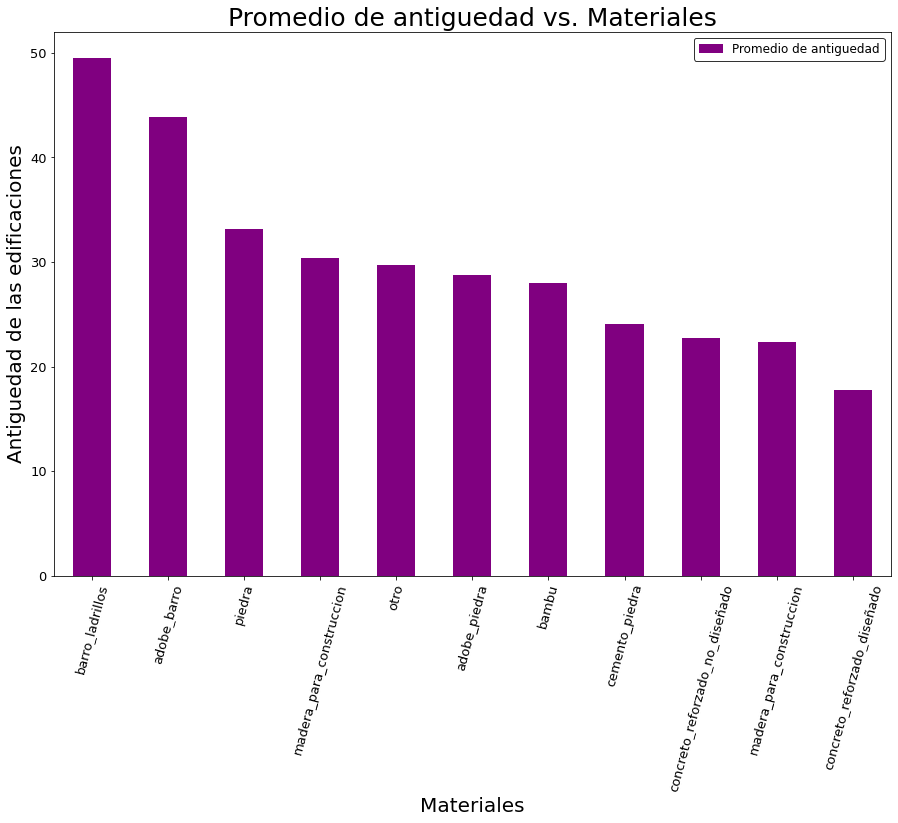

In [371]:
grafico=materials_and_age_mean_df.plot(kind='bar',color='purple', figsize=(15,10))
plt.title("Promedio de antiguedad vs. Materiales", size = 25)
plt.xlabel("Materiales", size=20)
plt.xticks(rotation=75, size = 13)
plt.ylabel("Antiguedad de las edificaciones", size=20)
plt.yticks(size = 13)
leyenda=plt.legend(['Promedio de antiguedad'],frameon=True,facecolor='white',edgecolor='black')

Para poder visualizar mejor toda esta informacion, ponemos un grafico en conjunto con todos estos datos

In [372]:
materials_age_damage_grade = materials_and_age_mean_df.merge(materials_vs_damage_mean_df ,on=materials_vs_damage_mean_df.index,how='inner')

materials_age_damage_grade = materials_age_damage_grade.set_index('key_0')

materials_age_damage_grade

,age_buildings,damage_grade
key_0,,
piedra,49.528455,2.452554
adobe_barro,43.917139,2.346782
adobe_piedra,33.153780,2.337901
barro_ladrillos,30.362911,2.271212
madera_para_construccion,29.750297,2.165222
madera_para_construccion,29.750297,1.693296
madera_para_construccion,22.380840,2.165222
madera_para_construccion,22.380840,1.693296
bambu,28.801067,2.111718


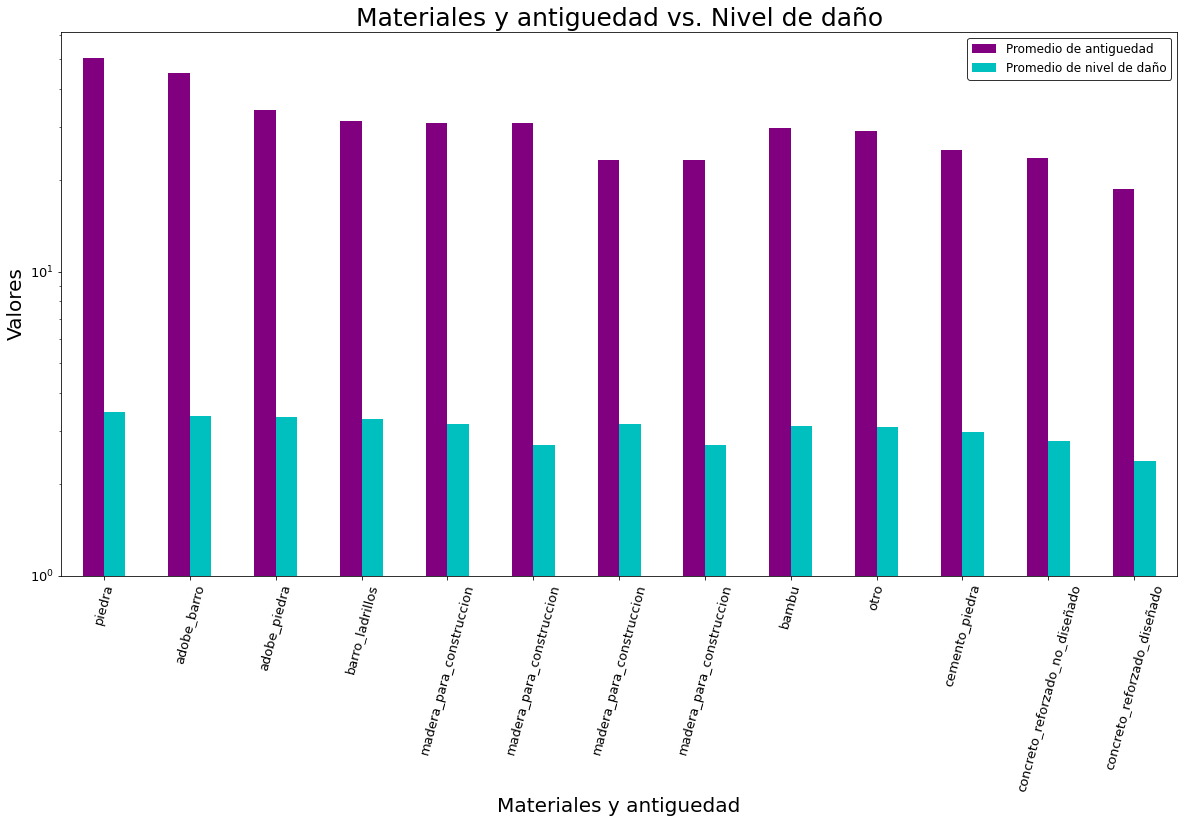

In [373]:
grafico=materials_age_damage_grade.plot(kind='bar',color=['purple','c'],log=True, figsize=(20,10))
plt.title("Materiales y antiguedad vs. Nivel de daño", size = 25)
plt.xlabel("Materiales y antiguedad", size=20)
plt.ylabel("Valores", size=20)
plt.yticks(size = 13)
plt.xticks(rotation=75, size = 13)
leyenda=plt.legend(['Promedio de antiguedad','Promedio de nivel de daño'],frameon=True,facecolor='white',edgecolor='black')

# Familias afectadas

In [374]:
train_values['count_families'].value_counts()

1    226115
0     20862
2     11294
3      1802
4       389
5       104
6        22
7         7
9         4
8         2
Name: count_families, dtype: int64

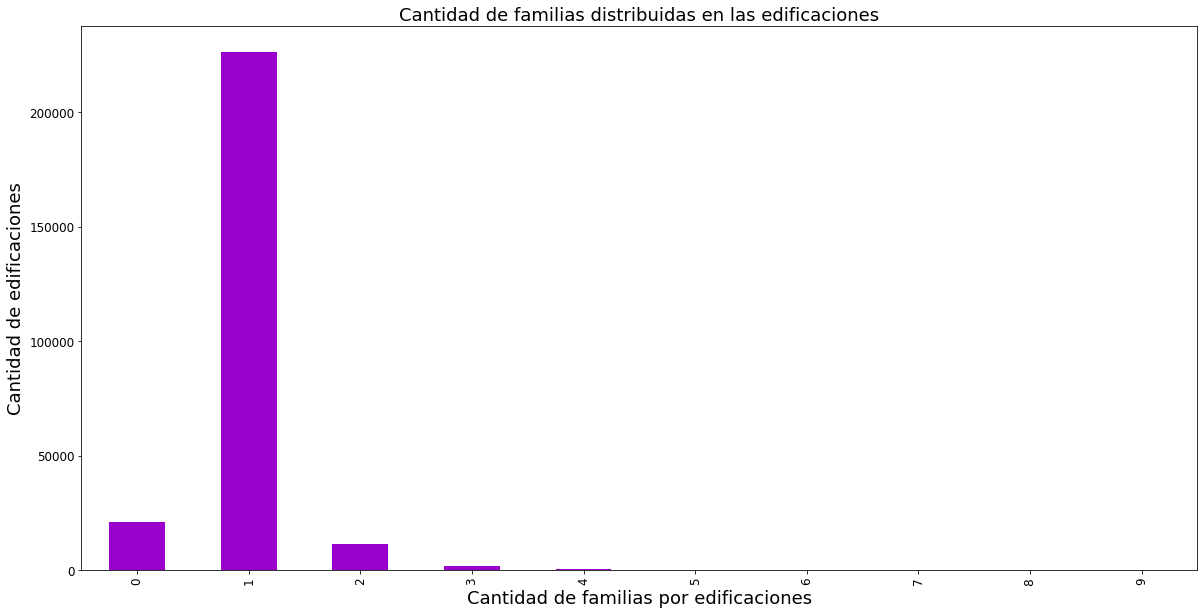

In [375]:
plot = train_values['count_families'].value_counts().sort_index().plot.bar(color=(0.6, 0, 0.8), figsize=(20,10))
plot.set_title("Cantidad de familias distribuidas en las edificaciones", fontsize=18)
plot.set_ylabel("Cantidad de edificaciones", fontsize=18);
plot.set_xlabel("Cantidad de familias por edificaciones", fontsize=18);

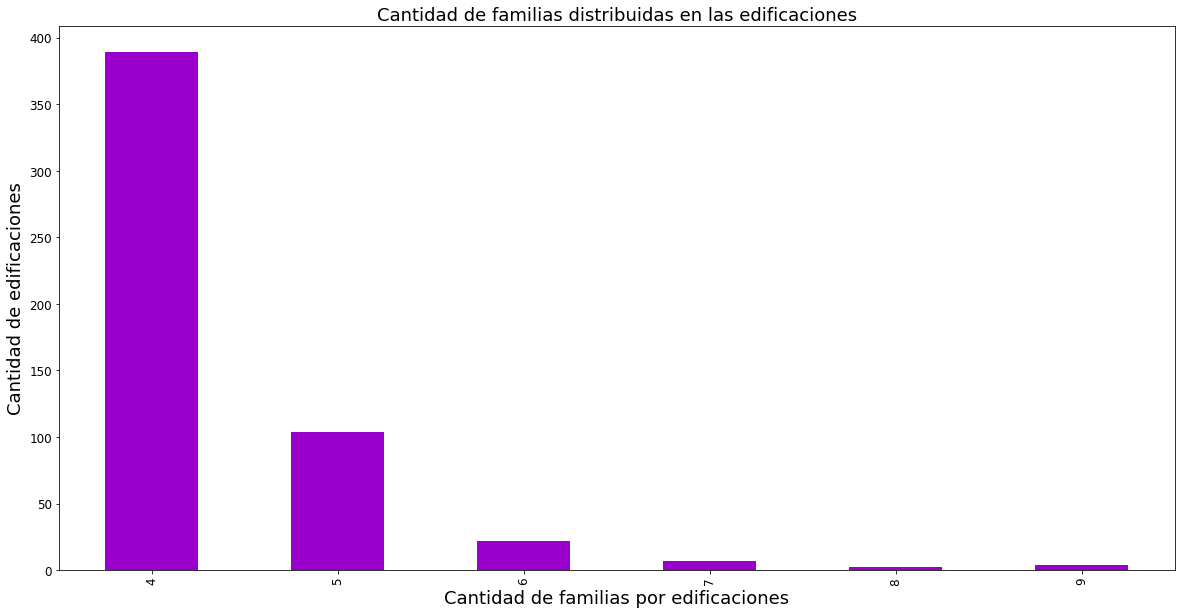

In [376]:
buildings_where_lives_more_than_3_families = train_values.loc[train_values['count_families'] >=4]
plot = buildings_where_lives_more_than_3_families['count_families'].value_counts().sort_index().plot.bar(color=(0.6, 0, 0.8), figsize=(20,10))
plot.set_title("Cantidad de familias distribuidas en las edificaciones", fontsize=18)
plot.set_ylabel("Cantidad de edificaciones", fontsize=18);
plot.set_xlabel("Cantidad de familias por edificaciones", fontsize=18);

In [377]:
train_values_reduced = train_values[['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_families']]
train_values_reduced_with_damage = train_values_reduced.merge(train_labels, left_on='building_id', right_on='building_id')
train_values_reduced_with_damage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   building_id     260601 non-null  int64
 1   geo_level_1_id  260601 non-null  int64
 2   geo_level_2_id  260601 non-null  int64
 3   geo_level_3_id  260601 non-null  int64
 4   count_families  260601 non-null  int64
 5   damage_grade    260601 non-null  int64
dtypes: int64(6)
memory usage: 13.9 MB


In [378]:
train_values_reduced_with_damage_for_affected_families = train_values_reduced_with_damage.loc[train_values_reduced_with_damage['count_families'] != 0, :]

In [379]:
affected_buildings = train_values_reduced_with_damage_for_affected_families.groupby(['count_families', 'damage_grade']).agg({'damage_grade':'count'})
affected_buildings.columns = ['damage_grade_count']
affected_buildings.reset_index(inplace=True)
affected_buildings.columns = ['Count families', 'Grado de daño', 'Damage grade count']
affected_buildings.head()

,Count families,Grado de daño,Damage grade count
0,1,1,20339
1,1,2,129721
2,1,3,76055
3,2,1,829
4,2,2,6021


In [380]:
affected_buildings_pivot = affected_buildings.pivot(index='Count families', columns='Grado de daño', values='Damage grade count')
affected_buildings_pivot = affected_buildings_pivot.fillna(0)
affected_buildings_pivot

Grado de daño,1,2,3
Count families,,,
1,20339.0,129721.0,76055.0
2,829.0,6021.0,4444.0
3,221.0,886.0,695.0
4,46.0,205.0,138.0
5,17.0,51.0,36.0
6,4.0,8.0,10.0
7,3.0,2.0,2.0
8,1.0,1.0,0.0
9,1.0,3.0,0.0


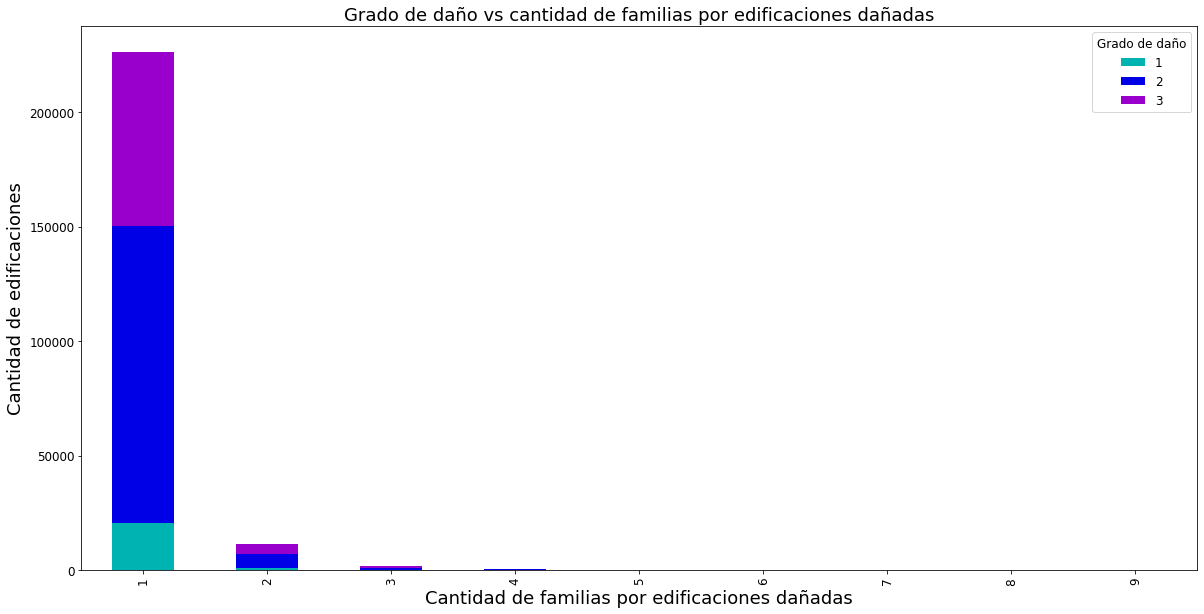

In [381]:
plot = affected_buildings_pivot.plot.bar(color=[(0, 0.7, 0.7), (0.0, 0.0, 0.9), (0.6, 0, 0.8)], stacked=True, figsize=(20,10))
plot.set_title("Grado de daño vs cantidad de familias por edificaciones dañadas", fontsize=18)
plot.set_ylabel("Cantidad de edificaciones", fontsize=18);
plot.set_xlabel("Cantidad de familias por edificaciones dañadas", fontsize=18);

In [382]:
#Para ir generadno los "zoom" en los gráficos, voy cambiando el "x"
x = 6
train_values_reduced_with_damage_for_affected_families_more_than_2 = train_values_reduced_with_damage.loc[train_values_reduced_with_damage['count_families'] >= x, :]

In [383]:
affected_buildings_more_than_2 = train_values_reduced_with_damage_for_affected_families_more_than_2.groupby(['count_families', 'damage_grade']).agg({'damage_grade':'count'})
affected_buildings_more_than_2.columns = ['damage_grade_count']
affected_buildings_more_than_2.reset_index(inplace=True)
affected_buildings_more_than_2.columns = ['Count families', 'Grado de daño', 'Damage grade count']
affected_buildings_more_than_2.head()

,Count families,Grado de daño,Damage grade count
0,6,1,4
1,6,2,8
2,6,3,10
3,7,1,3
4,7,2,2


In [384]:
affected_buildings_more_than_2_pivot = affected_buildings_more_than_2.pivot(index='Count families', columns='Grado de daño', values='Damage grade count')
affected_buildings_more_than_2_pivot = affected_buildings_more_than_2_pivot.fillna(0)
affected_buildings_more_than_2_pivot

Grado de daño,1,2,3
Count families,,,
6,4.0,8.0,10.0
7,3.0,2.0,2.0
8,1.0,1.0,0.0
9,1.0,3.0,0.0


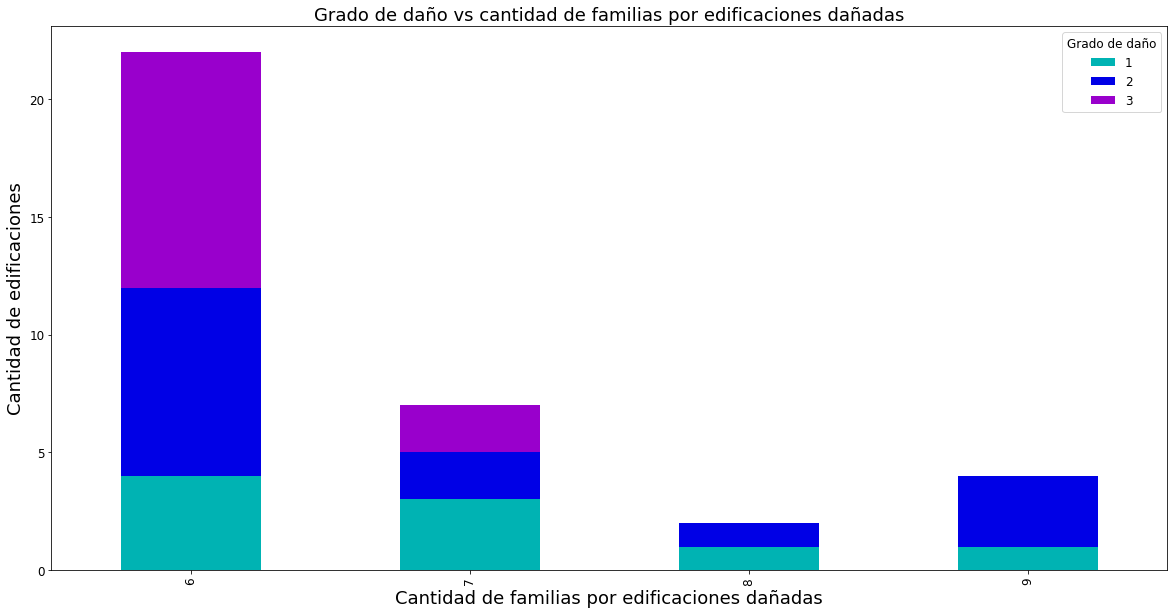

In [385]:
plot = affected_buildings_more_than_2_pivot.plot.bar(color=[(0, 0.7, 0.7), (0.0, 0.0, 0.9), (0.6, 0, 0.8)], stacked=True, figsize=(20,10))
plot.set_title("Grado de daño vs cantidad de familias por edificaciones dañadas", fontsize=18)
plot.set_ylabel("Cantidad de edificaciones", fontsize=18);
plot.set_xlabel("Cantidad de familias por edificaciones dañadas", fontsize=18);

 A continuación, veremos los daños que recibieron los edificios donde vivía una sola familia en los distritos de las tres regiones:

In [386]:
affected_buildings_where_lives_1_family = train_values_reduced_with_damage_for_affected_families.loc[train_values_reduced_with_damage_for_affected_families['count_families'] == 1, :]

* Región 1

In [387]:
affected_buildings_where_lives_1_family_region_1 = affected_buildings_where_lives_1_family.groupby(['geo_level_1_id', 'damage_grade']).agg({'damage_grade':'count'})
affected_buildings_where_lives_1_family_region_1.columns = ['damage_grade_count']
affected_buildings_where_lives_1_family_region_1.reset_index(inplace=True)
affected_buildings_where_lives_1_family_region_1.columns = ['Region 1', 'Grado de daño', 'Damage grade count']
affected_buildings_where_lives_1_family_region_1.head()

,Region 1,Grado de daño,Damage grade count
0,0,1,320
1,0,2,3000
2,0,3,589
3,1,1,390
4,1,2,1921


In [388]:
affected_buildings_where_lives_1_family_region_1_pivot = affected_buildings_where_lives_1_family_region_1.pivot(index='Region 1', columns='Grado de daño', values='Damage grade count')
affected_buildings_where_lives_1_family_region_1_pivot = affected_buildings_where_lives_1_family_region_1_pivot.fillna(0)
affected_buildings_where_lives_1_family_region_1_pivot.head()

Grado de daño,1,2,3
Region 1,,,
0,320.0,3000.0,589.0
1,390.0,1921.0,302.0
2,78.0,570.0,230.0
3,125.0,4079.0,2544.0
4,412.0,9474.0,2450.0


In [389]:
#Normalizamos las columnas
total = affected_buildings_where_lives_1_family_region_1_pivot[1] + affected_buildings_where_lives_1_family_region_1_pivot[2] + affected_buildings_where_lives_1_family_region_1_pivot[3]
affected_buildings_where_lives_1_family_region_1_pivot[1] = affected_buildings_where_lives_1_family_region_1_pivot[1]/total
affected_buildings_where_lives_1_family_region_1_pivot[2] = affected_buildings_where_lives_1_family_region_1_pivot[2]/total
affected_buildings_where_lives_1_family_region_1_pivot[3] = affected_buildings_where_lives_1_family_region_1_pivot[3]/total
affected_buildings_where_lives_1_family_region_1_pivot.head()

Grado de daño,1,2,3
Region 1,,,
0,0.081862,0.767460,0.150678
1,0.149254,0.735170,0.115576
2,0.088838,0.649203,0.261959
3,0.018524,0.604475,0.377001
4,0.033398,0.767996,0.198606


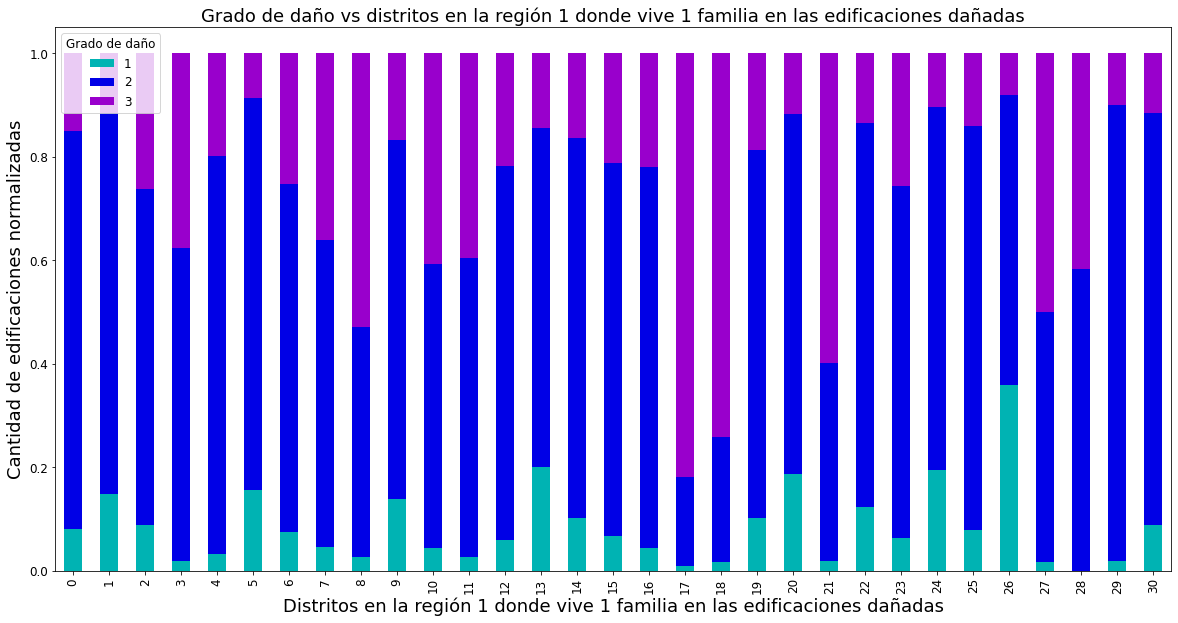

In [390]:
plot = affected_buildings_where_lives_1_family_region_1_pivot.plot.bar(color=[(0, 0.7, 0.7), (0.0, 0.0, 0.9), (0.6, 0, 0.8)],stacked=True, figsize=(20,10))
plot.set_title("Grado de daño vs distritos en la región 1 donde vive 1 familia en las edificaciones dañadas", fontsize=18)
plot.set_ylabel("Cantidad de edificaciones normalizadas", fontsize=18);
plot.set_xlabel("Distritos en la región 1 donde vive 1 familia en las edificaciones dañadas", fontsize=18);

* Región 2

In [391]:
affected_buildings_where_lives_1_family_region_2 = affected_buildings_where_lives_1_family.groupby('geo_level_2_id').agg({'damage_grade':'mean'})
affected_buildings_where_lives_1_family_region_2.columns = ['damage_grade_mean']
affected_buildings_where_lives_1_family_region_2.reset_index(inplace=True)
affected_buildings_where_lives_1_family_region_2.columns = ['Region 2', 'Damage grade mean']
affected_buildings_where_lives_1_family_region_2.head()

,Region 2,Damage grade mean
0,0,3.000000
1,1,2.366120
2,3,2.103896
3,4,2.540351
4,5,2.160000


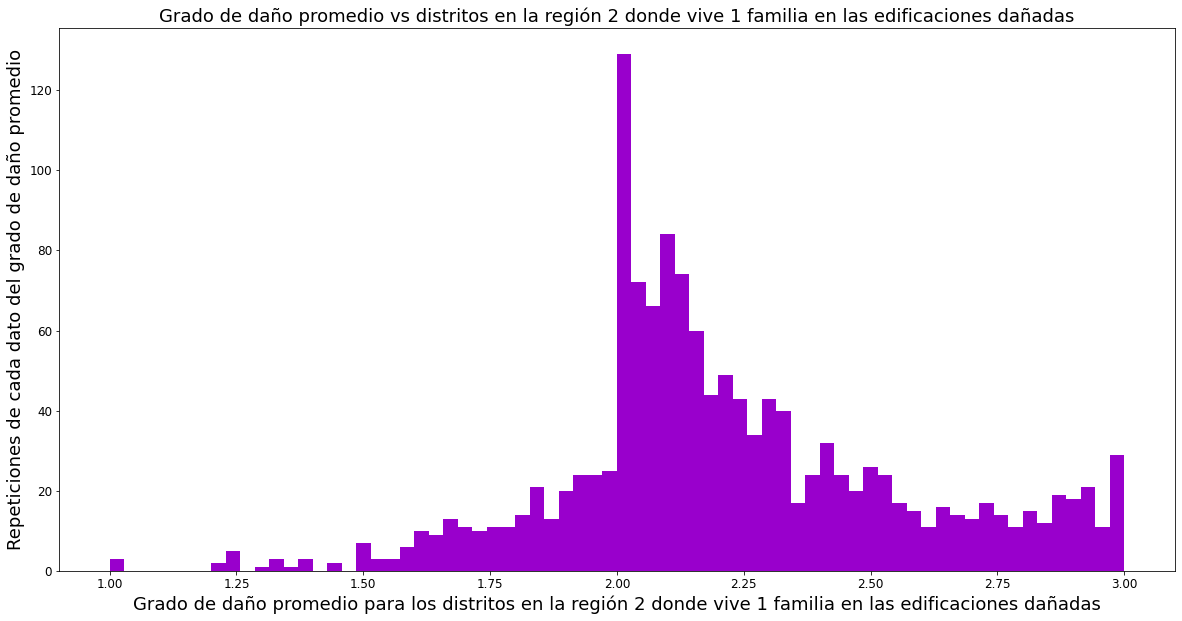

In [392]:
plot = affected_buildings_where_lives_1_family_region_2['Damage grade mean'].plot.hist(color=(0.6, 0, 0.8), bins=70, figsize=(20,10)) 
plot.set_title("Grado de daño promedio vs distritos en la región 2 donde vive 1 familia en las edificaciones dañadas", fontsize=18)
plot.set_ylabel("Repeticiones de cada dato del grado de daño promedio", fontsize=18);
plot.set_xlabel("Grado de daño promedio para los distritos en la región 2 donde vive 1 familia en las edificaciones dañadas", fontsize=18);

* Región 3

In [393]:
affected_buildings_where_lives_1_family_region_3 = affected_buildings_where_lives_1_family.groupby('geo_level_3_id').agg({'damage_grade':'mean'})
affected_buildings_where_lives_1_family_region_3.columns = ['damage_grade_mean']
affected_buildings_where_lives_1_family_region_3.reset_index(inplace=True)
affected_buildings_where_lives_1_family_region_3.columns = ['Region 3', 'Damage grade mean']
affected_buildings_where_lives_1_family_region_3.head()

,Region 3,Damage grade mean
0,0,3.000000
1,1,2.500000
2,3,1.875000
3,5,1.153846
4,6,2.684211


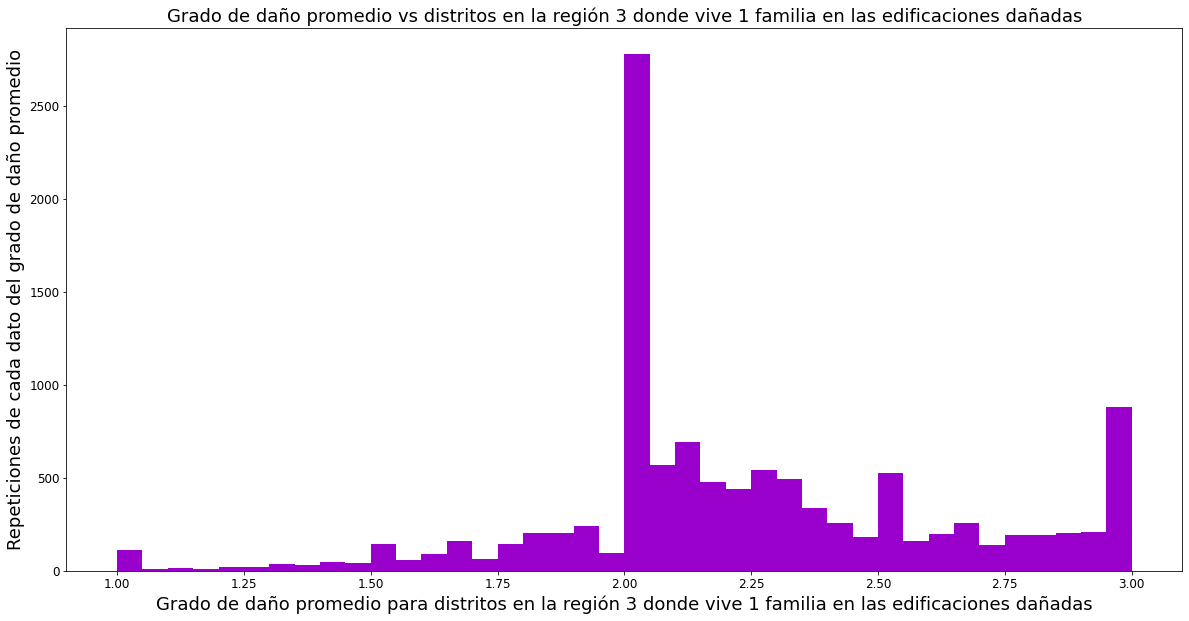

In [394]:
plot = affected_buildings_where_lives_1_family_region_3['Damage grade mean'].plot.hist(color=(0.6, 0, 0.8), bins=40, figsize=(20,10))
plot.set_title("Grado de daño promedio vs distritos en la región 3 donde vive 1 familia en las edificaciones dañadas", fontsize=18)
plot.set_ylabel("Repeticiones de cada dato del grado de daño promedio", fontsize=18);
plot.set_xlabel("Grado de daño promedio para distritos en la región 3 donde vive 1 familia en las edificaciones dañadas", fontsize=18);

 A continuación, veremos los daños que recibieron los edificios donde vivía más de una sola familia en los distritos de las tres regiones:

In [395]:
affected_buildings_where_lives_more_than_1_family = train_values_reduced_with_damage_for_affected_families.loc[train_values_reduced_with_damage_for_affected_families['count_families'] > 1, :]

* Región 1

In [396]:
affected_buildings_where_lives_more_than_1_family_region_1 = affected_buildings_where_lives_more_than_1_family.groupby(['geo_level_1_id', 'damage_grade']).agg({'damage_grade':'count'})
affected_buildings_where_lives_more_than_1_family_region_1.columns = ['damage_grade_count']
affected_buildings_where_lives_more_than_1_family_region_1.reset_index(inplace=True)
affected_buildings_where_lives_more_than_1_family_region_1.columns = ['Region 1', 'Grado de daño', 'Damage grade count']
affected_buildings_where_lives_more_than_1_family_region_1.head()

,Region 1,Grado de daño,Damage grade count
0,0,2,16
1,0,3,4
2,1,1,11
3,1,2,30
4,1,3,2


In [397]:
affected_buildings_where_lives_more_than_1_family_region_1_pivot = affected_buildings_where_lives_more_than_1_family_region_1.pivot(index='Region 1', columns='Grado de daño', values='Damage grade count')
affected_buildings_where_lives_more_than_1_family_region_1_pivot = affected_buildings_where_lives_more_than_1_family_region_1_pivot.fillna(0)
affected_buildings_where_lives_more_than_1_family_region_1_pivot.head()

Grado de daño,1,2,3
Region 1,,,
0,0.0,16.0,4.0
1,11.0,30.0,2.0
2,0.0,3.0,5.0
3,0.0,317.0,151.0
4,27.0,511.0,94.0


In [398]:
#Normalizamos las columnas
total = affected_buildings_where_lives_more_than_1_family_region_1_pivot[1] + affected_buildings_where_lives_more_than_1_family_region_1_pivot[2] + affected_buildings_where_lives_more_than_1_family_region_1_pivot[3]
affected_buildings_where_lives_more_than_1_family_region_1_pivot[1] = affected_buildings_where_lives_more_than_1_family_region_1_pivot[1]/total
affected_buildings_where_lives_more_than_1_family_region_1_pivot[2] = affected_buildings_where_lives_more_than_1_family_region_1_pivot[2]/total
affected_buildings_where_lives_more_than_1_family_region_1_pivot[3] = affected_buildings_where_lives_more_than_1_family_region_1_pivot[3]/total
affected_buildings_where_lives_more_than_1_family_region_1_pivot.head()

Grado de daño,1,2,3
Region 1,,,
0,0.000000,0.800000,0.200000
1,0.255814,0.697674,0.046512
2,0.000000,0.375000,0.625000
3,0.000000,0.677350,0.322650
4,0.042722,0.808544,0.148734


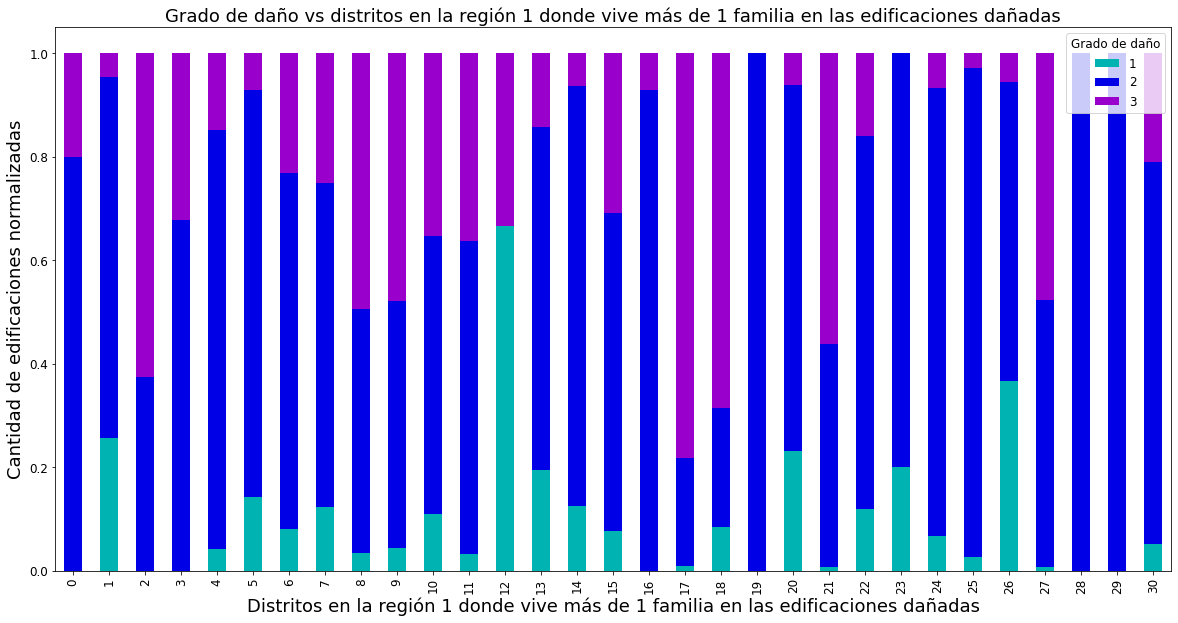

In [399]:
plot = affected_buildings_where_lives_more_than_1_family_region_1_pivot.plot.bar(color=[(0, 0.7, 0.7), (0.0, 0.0, 0.9), (0.6, 0, 0.8)],stacked=True, figsize=(20,10))
plot.set_title("Grado de daño vs distritos en la región 1 donde vive más de 1 familia en las edificaciones dañadas", fontsize=18)
plot.set_ylabel("Cantidad de edificaciones normalizadas", fontsize=18);
plot.set_xlabel("Distritos en la región 1 donde vive más de 1 familia en las edificaciones dañadas", fontsize=18);

* Región 2

In [400]:
affected_buildings_where_lives_more_than_1_family_region_2 = affected_buildings_where_lives_more_than_1_family.groupby('geo_level_2_id').agg({'damage_grade':'mean'})
affected_buildings_where_lives_more_than_1_family_region_2.columns = ['damage_grade_mean']
affected_buildings_where_lives_more_than_1_family_region_2.reset_index(inplace=True)
affected_buildings_where_lives_more_than_1_family_region_2.columns = ['Region 2', 'Damage grade mean']
affected_buildings_where_lives_more_than_1_family_region_2.head()

,Region 2,Damage grade mean
0,0,3.00000
1,1,2.50000
2,4,2.35000
3,7,2.37037
4,8,2.20000


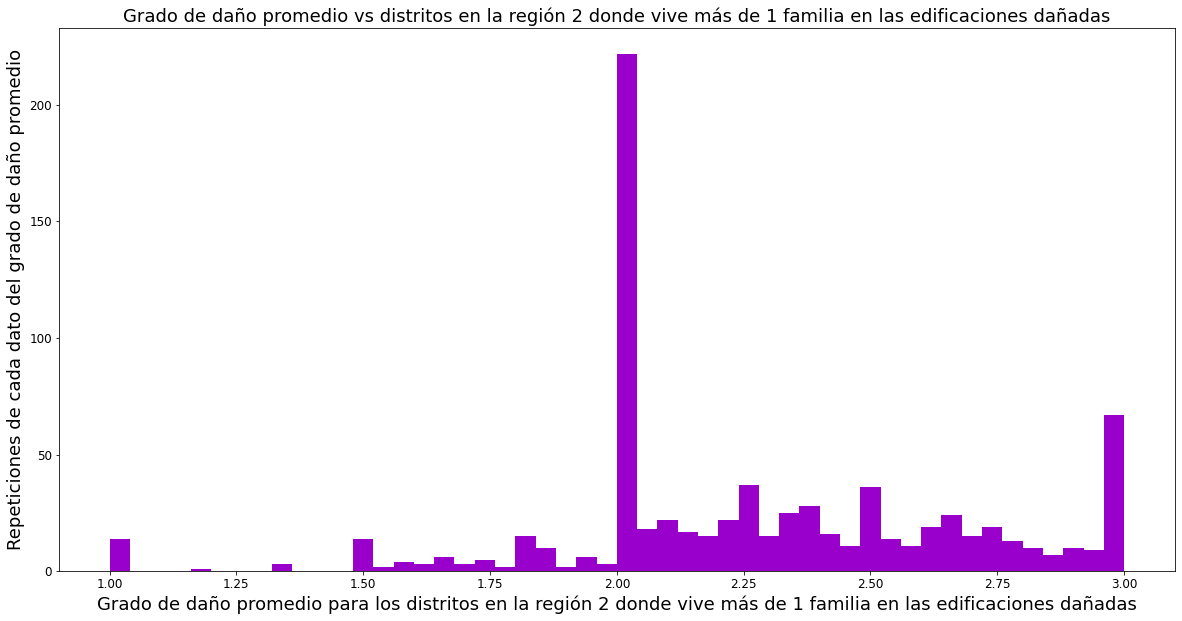

In [401]:
plot = affected_buildings_where_lives_more_than_1_family_region_2['Damage grade mean'].plot.hist(color=(0.6, 0, 0.8), bins=50, figsize=(20,10))
plot.set_title("Grado de daño promedio vs distritos en la región 2 donde vive más de 1 familia en las edificaciones dañadas", fontsize=18)
plot.set_ylabel("Repeticiones de cada dato del grado de daño promedio", fontsize=18);
plot.set_xlabel("Grado de daño promedio para los distritos en la región 2 donde vive más de 1 familia en las edificaciones dañadas", fontsize=18);

* Región 3

In [402]:
affected_buildings_where_lives_more_than_1_family_region_3 = affected_buildings_where_lives_more_than_1_family.groupby('geo_level_3_id').agg({'damage_grade':'mean'})
affected_buildings_where_lives_more_than_1_family_region_3.columns = ['damage_grade_mean']
affected_buildings_where_lives_more_than_1_family_region_3.reset_index(inplace=True)
affected_buildings_where_lives_more_than_1_family_region_3.columns = ['Region 3', 'Damage grade mean']
affected_buildings_where_lives_more_than_1_family_region_3.head()

,Region 3,Damage grade mean
0,5,1.0
1,8,3.0
2,11,2.6
3,14,2.0
4,16,2.0


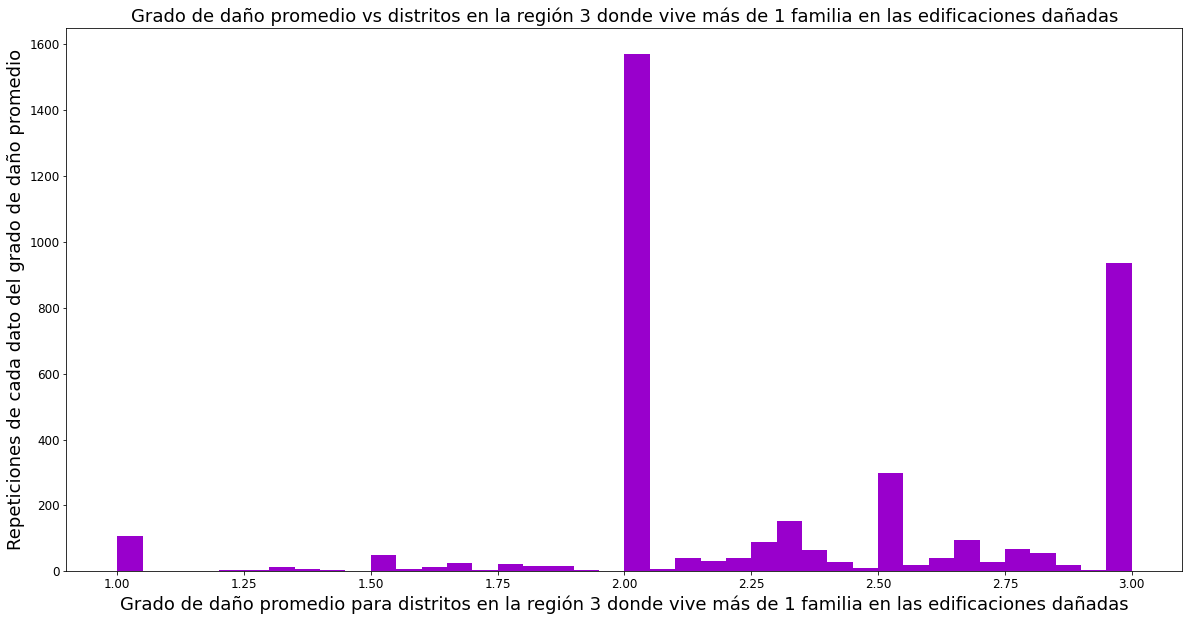

In [403]:
plot = affected_buildings_where_lives_more_than_1_family_region_3['Damage grade mean'].plot.hist(color=(0.6, 0, 0.8), bins=40, figsize=(20,10))
plot.set_title("Grado de daño promedio vs distritos en la región 3 donde vive más de 1 familia en las edificaciones dañadas", fontsize=18)
plot.set_ylabel("Repeticiones de cada dato del grado de daño promedio", fontsize=18);
plot.set_xlabel("Grado de daño promedio para distritos en la región 3 donde vive más de 1 familia en las edificaciones dañadas", fontsize=18);

# Edificios de uso secundario

Análisis previo

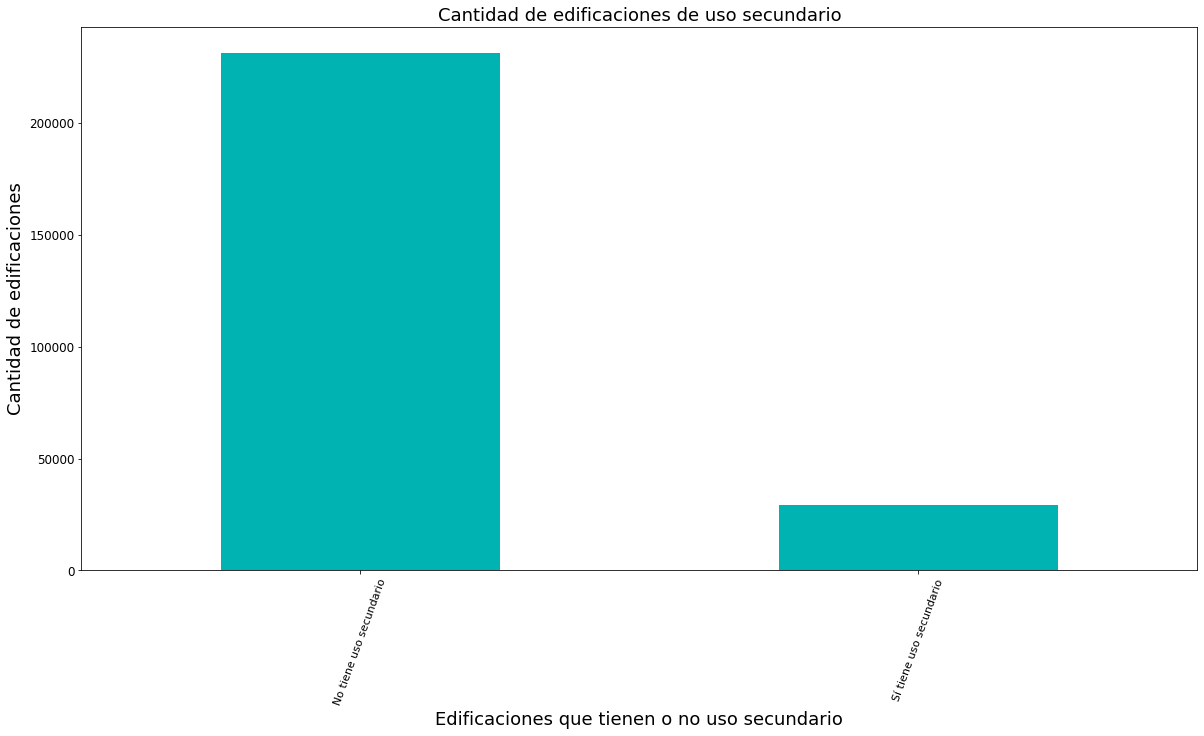

In [404]:
plot = train_values['has_secondary_use'].value_counts().plot.bar(color=(0, 0.7, 0.7), figsize=(20,10))
plot.set_title("Cantidad de edificaciones de uso secundario", fontsize=18)
plot.set_xticklabels(["No tiene uso secundario", "Sí tiene uso secundario"], rotation=70, fontsize=11.0)
plot.set_ylabel("Cantidad de edificaciones", fontsize=18);
plot.set_xlabel("Edificaciones que tienen o no uso secundario", fontsize=18); 

Ahora arrancamos con el análisis

In [405]:
train_values_reduced = train_values.iloc[:,[0, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]]
train_values_reduced_with_damage = train_values_reduced.merge(train_labels, left_on='building_id', right_on='building_id')
train_values_reduced_with_damage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   building_id                    260601 non-null  int64
 1   count_families                 260601 non-null  int64
 2   has_secondary_use              260601 non-null  int64
 3   has_secondary_use_agriculture  260601 non-null  int64
 4   has_secondary_use_hotel        260601 non-null  int64
 5   has_secondary_use_rental       260601 non-null  int64
 6   has_secondary_use_institution  260601 non-null  int64
 7   has_secondary_use_school       260601 non-null  int64
 8   has_secondary_use_industry     260601 non-null  int64
 9   has_secondary_use_health_post  260601 non-null  int64
 10  has_secondary_use_gov_office   260601 non-null  int64
 11  has_secondary_use_use_police   260601 non-null  int64
 12  has_secondary_use_other        260601 non-null  int64
 13 

In [406]:
train_values_reduced_with_damage_buildings_with_secondary_use = train_values_reduced_with_damage.loc[train_values_reduced_with_damage['has_secondary_use'].eq(1), :]

In [407]:
train_values_reduced_with_damage_buildings_agriculture = train_values_reduced_with_damage_buildings_with_secondary_use.groupby('has_secondary_use_agriculture').agg({'damage_grade':'mean'}).drop(index=0)
train_values_reduced_with_damage_buildings_agriculture.reset_index(inplace=True)

In [408]:
train_values_reduced_with_damage_buildings_hotel = train_values_reduced_with_damage_buildings_with_secondary_use.groupby('has_secondary_use_hotel').agg({'damage_grade':'mean'}).drop(index=0)
train_values_reduced_with_damage_buildings_hotel.reset_index(inplace=True)

In [409]:
train_values_reduced_with_damage_buildings_rental = train_values_reduced_with_damage_buildings_with_secondary_use.groupby('has_secondary_use_rental').agg({'damage_grade':'mean'}).drop(index=0)
train_values_reduced_with_damage_buildings_rental.reset_index(inplace=True)

In [410]:
train_values_reduced_with_damage_buildings_institution = train_values_reduced_with_damage_buildings_with_secondary_use.groupby('has_secondary_use_institution').agg({'damage_grade':'mean'}).drop(index=0)
train_values_reduced_with_damage_buildings_institution.reset_index(inplace=True)

In [411]:
train_values_reduced_with_damage_buildings_school = train_values_reduced_with_damage_buildings_with_secondary_use.groupby('has_secondary_use_school').agg({'damage_grade':'mean'}).drop(index=0)
train_values_reduced_with_damage_buildings_school.reset_index(inplace=True)

In [412]:
train_values_reduced_with_damage_buildings_industry = train_values_reduced_with_damage_buildings_with_secondary_use.groupby('has_secondary_use_industry').agg({'damage_grade':'mean'}).drop(index=0)
train_values_reduced_with_damage_buildings_industry.reset_index(inplace=True)

In [413]:
train_values_reduced_with_damage_buildings_health_post = train_values_reduced_with_damage_buildings_with_secondary_use.groupby('has_secondary_use_health_post').agg({'damage_grade':'mean'}).drop(index=0)
train_values_reduced_with_damage_buildings_health_post.reset_index(inplace=True)

In [414]:
train_values_reduced_with_damage_buildings_gov_office = train_values_reduced_with_damage_buildings_with_secondary_use.groupby('has_secondary_use_gov_office').agg({'damage_grade':'mean'}).drop(index=0)
train_values_reduced_with_damage_buildings_gov_office.reset_index(inplace=True)

In [415]:
train_values_reduced_with_damage_buildings_police = train_values_reduced_with_damage_buildings_with_secondary_use.groupby('has_secondary_use_use_police').agg({'damage_grade':'mean'}).drop(index=0)
train_values_reduced_with_damage_buildings_police.reset_index(inplace=True)

In [416]:
train_values_reduced_with_damage_buildings_other = train_values_reduced_with_damage_buildings_with_secondary_use.groupby('has_secondary_use_other').agg({'damage_grade':'mean'}).drop(index=0)
train_values_reduced_with_damage_buildings_other.reset_index(inplace=True)

In [417]:
aux_list = [train_values_reduced_with_damage_buildings_agriculture, train_values_reduced_with_damage_buildings_hotel, train_values_reduced_with_damage_buildings_rental, train_values_reduced_with_damage_buildings_institution, train_values_reduced_with_damage_buildings_school, train_values_reduced_with_damage_buildings_industry, train_values_reduced_with_damage_buildings_health_post, train_values_reduced_with_damage_buildings_gov_office, train_values_reduced_with_damage_buildings_police, train_values_reduced_with_damage_buildings_other]
train_values_reduced_with_damage_buildings_with_secondary_use_aux = pd.concat(aux_list)

In [418]:
train_values_reduced_with_damage_buildings_with_secondary_use_aux

,has_secondary_use_agriculture,damage_grade,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,1.0,2.264648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,1.917038,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,1.671246,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,1.665306,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,1.861702,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
0,NaN,2.032258,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
0,NaN,1.857143,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
0,NaN,1.763158,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
0,NaN,2.130435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
0,NaN,2.098951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [419]:
train_values_reduced_with_damage_buildings_with_secondary_use_aux.iloc[0,0] = 'Edificaciones de agricultura'
train_values_reduced_with_damage_buildings_with_secondary_use_aux.iloc[1,0] = 'Hoteles'
train_values_reduced_with_damage_buildings_with_secondary_use_aux.iloc[2,0] = 'Edificaciones para alquiler'
train_values_reduced_with_damage_buildings_with_secondary_use_aux.iloc[3,0] = 'Instituciones'
train_values_reduced_with_damage_buildings_with_secondary_use_aux.iloc[4,0] = 'Escuelas'
train_values_reduced_with_damage_buildings_with_secondary_use_aux.iloc[5,0] = 'Edificaciiones para la industria'
train_values_reduced_with_damage_buildings_with_secondary_use_aux.iloc[6,0] = 'Puestos de salud'
train_values_reduced_with_damage_buildings_with_secondary_use_aux.iloc[7,0] = 'Oficinas gubernamentales'
train_values_reduced_with_damage_buildings_with_secondary_use_aux.iloc[8,0] = 'Estaciones de policía'
train_values_reduced_with_damage_buildings_with_secondary_use_aux.iloc[9,0] = 'Edificaciones con otros usos'
train_values_reduced_with_damage_buildings_with_secondary_use_aux.drop(columns=['has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other'], inplace=True)
train_values_reduced_with_damage_buildings_with_secondary_use_aux

,has_secondary_use_agriculture,damage_grade
0,Edificaciones de agricultura,2.264648
0,Hoteles,1.917038
0,Edificaciones para alquiler,1.671246
0,Instituciones,1.665306
0,Escuelas,1.861702
0,Edificaciiones para la industria,2.032258
0,Puestos de salud,1.857143
0,Oficinas gubernamentales,1.763158
0,Estaciones de policía,2.130435
0,Edificaciones con otros usos,2.098951


In [420]:
buildings_with_secondary_use_averege_damage = train_values_reduced_with_damage_buildings_with_secondary_use_aux.set_index('has_secondary_use_agriculture')
buildings_with_secondary_use_averege_damage.columns = ['Grado de daño promedio'] 

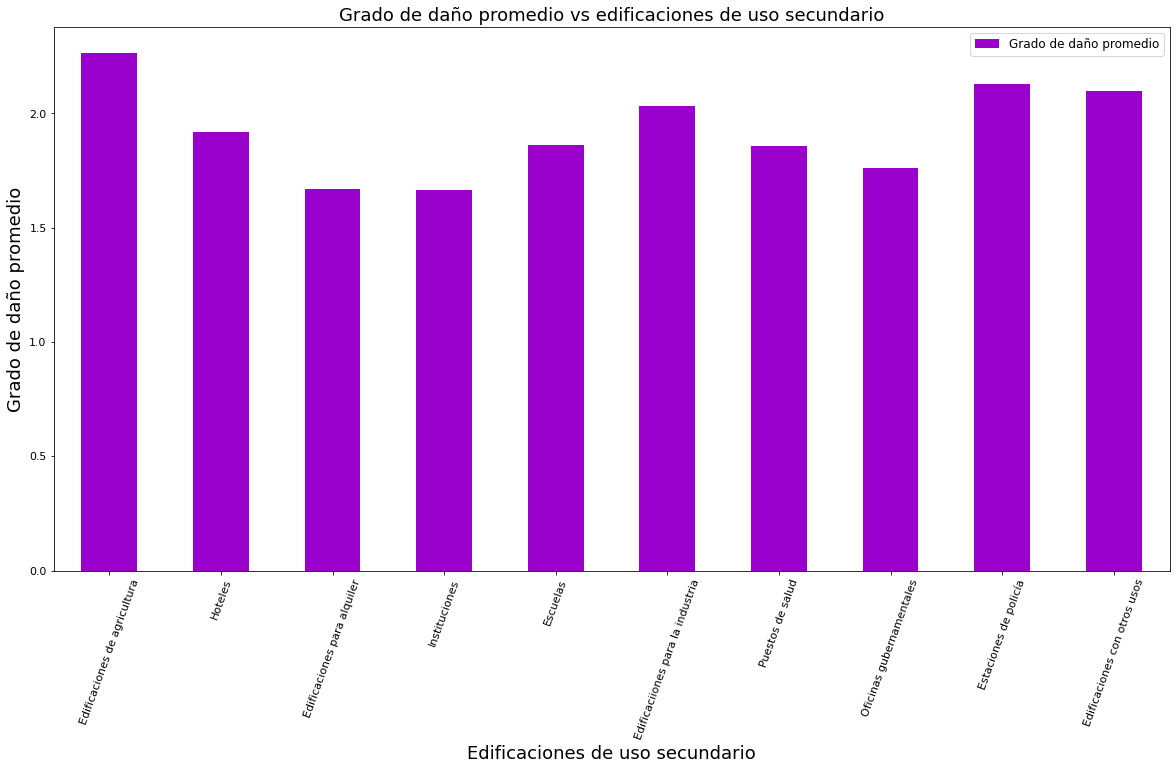

In [421]:
plot = buildings_with_secondary_use_averege_damage.plot.bar(rot=70, color=(0.6, 0, 0.8), fontsize=11.0, figsize=(20,10))
plot.set_title("Grado de daño promedio vs edificaciones de uso secundario", fontsize=18)
plot.set_ylabel("Grado de daño promedio", fontsize=18);
plot.set_xlabel("Edificaciones de uso secundario", fontsize=18);